In [1]:
import os
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

/tmp/ipykernel_906854/2694772781.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#savedir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/'
savedir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/'
#dfs_dir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/embeddings/ukb40_epoch80_embeddings'
#dfs_dir = '/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation_latent_256/embeddings/ukb40_epoch80_embeddings'
n_dims = 32
#nb_subs = None
nb_subs = 5000
#metric = 'roc_auc_ovr_weighted'
metric = 'balanced_accuracy'
dims = [f'dim{k}' for k in range(1, n_dims+1)]

regions_to_treat = ['SOr_left',
 'SOr_right',
 'FColl-SRh_left',
 'SFmedian-SFpoltr-SFsup_left',
 'SFinf-BROCA-SPeCinf_left',
 'SPoC_left',
 'fronto-parietal_medial_face_left',
 'FIP_left',
 'CINGULATE_left',
 'SC-SPoC_left',
 'SFinter-SFsup_left',
 'FCMpost-SpC_left',
 'SsP-SPaint_left',
 'SOr-SOlf_left',
 'FPO-SCu-ScCal_left',
 'LARGE_CINGULATE_left',
 'SFmarginal-SFinfant_left',
 'SFint-FCMant_left',
 'STi-STs-STpol_left',
 'SFint-SR_left',
 'Lobule_parietal_sup_left',
 'STi-SOTlat_left',
 'SPeC_left',
 'STsbr_left',
 'ScCal-SLi_left',
 'STs_left',
 'FCLp-subsc-FCLa-INSULA_left',
 'SC-sylv_left',
 'SC-SPeC_left',
 'OCCIPITAL_left',
 'FColl-SRh_right',
 'SFmedian-SFpoltr-SFsup_right',
 'SFinf-BROCA-SPeCinf_right',
 'SPoC_right',
 'fronto-parietal_medial_face_right',
 'FIP_right',
 'CINGULATE_right',
 'SC-SPoC_right',
 'SFinter-SFsup_right',
 'FCMpost-SpC_right',
 'SsP-SPaint_right',
 'SOr-SOlf_right',
 'FPO-SCu-ScCal_right',
 'LARGE_CINGULATE_right',
 'SFmarginal-SFinfant_right',
 'SFint-FCMant_right',
 'STi-STs-STpol_right',
 'SFint-SR_right',
 'Lobule_parietal_sup_right',
 'STi-SOTlat_right',
 'SPeC_right',
 'STsbr_right',
 'ScCal-SLi_right',
 'STs_right',
 'FCLp-subsc-FCLa-INSULA_right',
 'SC-sylv_right',
 'SC-SPeC_right',
 'OCCIPITAL_right']

# UKB # TODO : labels dir is also a parameter ...
dataset = 'ukb40'

keywords = ['_left', '_right']
all_matches = []
for var in keywords:
    pattern = f"{savedir}*{var}/*/{dataset}_random_embeddings/train_val_embeddings.csv" ## TODO : Make sure only one model per region, take highest epoch, and print
    matches = glob.glob(pattern)
    all_matches.extend(matches)
# Optional: remove duplicates
dfs_dirs = list(set(all_matches))
dfs_dirs.sort()

regions_treated = [elem.split(savedir)[1].split('/')[0] for elem in dfs_dirs]
print(regions_treated)
print(f'Number of regions treated : {len(regions_treated)}')
print(f'Missing regions : {set(regions_to_treat) - set(regions_treated)}')

['CINGULATE_left', 'CINGULATE_right', 'FCLp-subsc-FCLa-INSULA_left', 'FCLp-subsc-FCLa-INSULA_right', 'FCMpost-SpC_left', 'FCMpost-SpC_right', 'FColl-SRh_left', 'FColl-SRh_right', 'FIP_left', 'FIP_right', 'FPO-SCu-ScCal_left', 'FPO-SCu-ScCal_right', 'LARGE_CINGULATE_left', 'LARGE_CINGULATE_right', 'Lobule_parietal_sup_left', 'Lobule_parietal_sup_right', 'OCCIPITAL_left', 'OCCIPITAL_right', 'SC-SPeC_left', 'SC-SPeC_right', 'SC-SPoC_left', 'SC-SPoC_right', 'SC-sylv_left', 'SC-sylv_right', 'SFinf-BROCA-SPeCinf_left', 'SFinf-BROCA-SPeCinf_right', 'SFint-FCMant_left', 'SFint-FCMant_right', 'SFint-SR_left', 'SFint-SR_right', 'SFinter-SFsup_left', 'SFinter-SFsup_right', 'SFmarginal-SFinfant_left', 'SFmarginal-SFinfant_right', 'SFmedian-SFpoltr-SFsup_left', 'SFmedian-SFpoltr-SFsup_right', 'SOr-SOlf_left', 'SOr-SOlf_right', 'SOr_left', 'SOr_right', 'SPeC_left', 'SPeC_right', 'SPoC_left', 'SPoC_right', 'STi-SOTlat_left', 'STi-SOTlat_right', 'STi-STs-STpol_left', 'STi-STs-STpol_right', 'STs_left',

In [44]:
# load the data
embd_list = []
print('Loading the embeddings...')
for i, directory in enumerate(tqdm(dfs_dirs)):
    embd=pd.read_csv(directory, nrows=nb_subs)
    embd_list.append(embd)

Loading the embeddings...


100%|██████████| 58/58 [00:02<00:00, 23.64it/s]


In [59]:
cca = CCA(n_components=n_dims)

corrs_matrix = np.zeros((len(regions_treated), len(regions_treated)), dtype=object)
for i, reg1 in enumerate(tqdm(regions_treated)):
    for j, reg2 in enumerate(regions_treated):
        if j >= i:
            pass
        else:
            X1 = embd_list[i][dims]
            X2 = embd_list[j][dims]
            cca.fit(X1, X2)
            X1_c, X2_c = cca.transform(X1, X2)
            corrs = [np.corrcoef(X1_c[:, i], X2_c[:, i])[0, 1] for i in range(n_dims)]
            corrs_matrix[i, j] = corrs
            corrs_matrix[j, i] = corrs
            print(f'score for {reg1} and {reg2} : {np.sum(np.square(corrs))}')

  3%|▎         | 2/58 [00:02<01:05,  1.17s/it]

score for CINGULATE_right and CINGULATE_left : 1.2214101240503137
score for FCLp-subsc-FCLa-INSULA_left and CINGULATE_left : 0.49058827920875836


  5%|▌         | 3/58 [00:06<02:12,  2.42s/it]

score for FCLp-subsc-FCLa-INSULA_left and CINGULATE_right : 0.39568648576986837
score for FCLp-subsc-FCLa-INSULA_right and CINGULATE_left : 0.45996023031464656
score for FCLp-subsc-FCLa-INSULA_right and CINGULATE_right : 0.4470500341871641


  7%|▋         | 4/58 [00:13<03:40,  4.08s/it]

score for FCLp-subsc-FCLa-INSULA_right and FCLp-subsc-FCLa-INSULA_left : 3.6843384292015147
score for FCMpost-SpC_left and CINGULATE_left : 2.258601338473075
score for FCMpost-SpC_left and CINGULATE_right : 0.6411240267178842
score for FCMpost-SpC_left and FCLp-subsc-FCLa-INSULA_left : 0.672886081197815


  9%|▊         | 5/58 [00:23<05:22,  6.09s/it]

score for FCMpost-SpC_left and FCLp-subsc-FCLa-INSULA_right : 0.6129182529965738
score for FCMpost-SpC_right and CINGULATE_left : 0.7799352280101803
score for FCMpost-SpC_right and CINGULATE_right : 1.583244490263617
score for FCMpost-SpC_right and FCLp-subsc-FCLa-INSULA_left : 0.5918567858928555
score for FCMpost-SpC_right and FCLp-subsc-FCLa-INSULA_right : 0.7429097851520903


 10%|█         | 6/58 [00:34<06:45,  7.80s/it]

score for FCMpost-SpC_right and FCMpost-SpC_left : 2.2839201733070045
score for FColl-SRh_left and CINGULATE_left : 0.4456740990944288
score for FColl-SRh_left and CINGULATE_right : 0.41273591633400053
score for FColl-SRh_left and FCLp-subsc-FCLa-INSULA_left : 1.8495128173008268
score for FColl-SRh_left and FCLp-subsc-FCLa-INSULA_right : 1.212663207426409
score for FColl-SRh_left and FCMpost-SpC_left : 0.6315796005009144


 12%|█▏        | 7/58 [00:45<07:28,  8.80s/it]

score for FColl-SRh_left and FCMpost-SpC_right : 0.6000580350018182
score for FColl-SRh_right and CINGULATE_left : 0.4869147679538062
score for FColl-SRh_right and CINGULATE_right : 0.46174533324798195
score for FColl-SRh_right and FCLp-subsc-FCLa-INSULA_left : 0.8557851119939196
score for FColl-SRh_right and FCLp-subsc-FCLa-INSULA_right : 1.1928771767334605
score for FColl-SRh_right and FCMpost-SpC_left : 0.6734912209725235
score for FColl-SRh_right and FCMpost-SpC_right : 0.722193347268554


 14%|█▍        | 8/58 [00:59<08:45, 10.50s/it]

score for FColl-SRh_right and FColl-SRh_left : 4.124705996214542
score for FIP_left and CINGULATE_left : 0.4011295817050108
score for FIP_left and CINGULATE_right : 0.34594025427902464
score for FIP_left and FCLp-subsc-FCLa-INSULA_left : 1.0552702801121157
score for FIP_left and FCLp-subsc-FCLa-INSULA_right : 0.760029426607795
score for FIP_left and FCMpost-SpC_left : 0.9399416650736185
score for FIP_left and FCMpost-SpC_right : 0.6925613886880008
score for FIP_left and FColl-SRh_left : 1.0732228498287066


 16%|█▌        | 9/58 [01:18<10:39, 13.04s/it]

score for FIP_left and FColl-SRh_right : 0.7949150460437295
score for FIP_right and CINGULATE_left : 0.37761538281303275
score for FIP_right and CINGULATE_right : 0.3767809344773072
score for FIP_right and FCLp-subsc-FCLa-INSULA_left : 0.7791014502004467
score for FIP_right and FCLp-subsc-FCLa-INSULA_right : 1.2950392665140873
score for FIP_right and FCMpost-SpC_left : 0.719946000695711
score for FIP_right and FCMpost-SpC_right : 0.9683769385203095
score for FIP_right and FColl-SRh_left : 0.662363820178185
score for FIP_right and FColl-SRh_right : 1.1945876286289032


 17%|█▋        | 10/58 [01:36<11:45, 14.69s/it]

score for FIP_right and FIP_left : 3.267797810524042
score for FPO-SCu-ScCal_left and CINGULATE_left : 0.5850889153807881
score for FPO-SCu-ScCal_left and CINGULATE_right : 0.5009419149411861
score for FPO-SCu-ScCal_left and FCLp-subsc-FCLa-INSULA_left : 1.0562366267349965
score for FPO-SCu-ScCal_left and FCLp-subsc-FCLa-INSULA_right : 0.8845849520516005
score for FPO-SCu-ScCal_left and FCMpost-SpC_left : 0.9172600973429562
score for FPO-SCu-ScCal_left and FCMpost-SpC_right : 0.8549850047145089
score for FPO-SCu-ScCal_left and FColl-SRh_left : 3.1331381353304115
score for FPO-SCu-ScCal_left and FColl-SRh_right : 1.8816371732284813
score for FPO-SCu-ScCal_left and FIP_left : 4.660741699560159


 19%|█▉        | 11/58 [01:57<12:58, 16.56s/it]

score for FPO-SCu-ScCal_left and FIP_right : 1.9104286391812417
score for FPO-SCu-ScCal_right and CINGULATE_left : 0.5006168018612641
score for FPO-SCu-ScCal_right and CINGULATE_right : 0.46683793803820073
score for FPO-SCu-ScCal_right and FCLp-subsc-FCLa-INSULA_left : 0.7411159028847751
score for FPO-SCu-ScCal_right and FCLp-subsc-FCLa-INSULA_right : 1.059334973937226
score for FPO-SCu-ScCal_right and FCMpost-SpC_left : 0.792966895732327
score for FPO-SCu-ScCal_right and FCMpost-SpC_right : 0.9061715196535818
score for FPO-SCu-ScCal_right and FColl-SRh_left : 1.408114672727649
score for FPO-SCu-ScCal_right and FColl-SRh_right : 3.6441509976116695
score for FPO-SCu-ScCal_right and FIP_left : 1.8758677460163329
score for FPO-SCu-ScCal_right and FIP_right : 4.557295545110586


 21%|██        | 12/58 [02:19<14:01, 18.30s/it]

score for FPO-SCu-ScCal_right and FPO-SCu-ScCal_left : 4.582920871099305


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for LARGE_CINGULATE_left and CINGULATE_left : 15.001182746828569
score for LARGE_CINGULATE_left and CINGULATE_right : 1.183147984672619
score for LARGE_CINGULATE_left and FCLp-subsc-FCLa-INSULA_left : 0.7447890053614831
score for LARGE_CINGULATE_left and FCLp-subsc-FCLa-INSULA_right : 0.6365264699810086
score for LARGE_CINGULATE_left and FCMpost-SpC_left : 7.2890042352818565
score for LARGE_CINGULATE_left and FCMpost-SpC_right : 1.5328238934467482
score for LARGE_CINGULATE_left and FColl-SRh_left : 0.6737450995547869
score for LARGE_CINGULATE_left and FColl-SRh_right : 0.6849155967113537
score for LARGE_CINGULATE_left and FIP_left : 0.7499054943910052
score for LARGE_CINGULATE_left and FIP_right : 0.613995442862592
score for LARGE_CINGULATE_left and FPO-SCu-ScCal_left : 0.9788835862228988


 22%|██▏       | 13/58 [02:45<15:19, 20.44s/it]

score for LARGE_CINGULATE_left and FPO-SCu-ScCal_right : 0.768795015728045
score for LARGE_CINGULATE_right and CINGULATE_left : 1.356237896303893
score for LARGE_CINGULATE_right and CINGULATE_right : 13.439226568677654
score for LARGE_CINGULATE_right and FCLp-subsc-FCLa-INSULA_left : 0.587768351265054
score for LARGE_CINGULATE_right and FCLp-subsc-FCLa-INSULA_right : 0.6975748077824804
score for LARGE_CINGULATE_right and FCMpost-SpC_left : 1.5108517702912851
score for LARGE_CINGULATE_right and FCMpost-SpC_right : 7.011321254256889
score for LARGE_CINGULATE_right and FColl-SRh_left : 0.5904297876694852
score for LARGE_CINGULATE_right and FColl-SRh_right : 0.7014838368913885
score for LARGE_CINGULATE_right and FIP_left : 0.5715288906111723
score for LARGE_CINGULATE_right and FIP_right : 0.6826709509025661
score for LARGE_CINGULATE_right and FPO-SCu-ScCal_left : 0.8029508151948253
score for LARGE_CINGULATE_right and FPO-SCu-ScCal_right : 0.8056120517430443


 24%|██▍       | 14/58 [03:09<15:53, 21.66s/it]

score for LARGE_CINGULATE_right and LARGE_CINGULATE_left : 2.177544210585539
score for Lobule_parietal_sup_left and CINGULATE_left : 0.40250937396654995
score for Lobule_parietal_sup_left and CINGULATE_right : 0.33981970360482094
score for Lobule_parietal_sup_left and FCLp-subsc-FCLa-INSULA_left : 1.0788346940549076
score for Lobule_parietal_sup_left and FCLp-subsc-FCLa-INSULA_right : 0.7866154582536948
score for Lobule_parietal_sup_left and FCMpost-SpC_left : 1.0845121192506502
score for Lobule_parietal_sup_left and FCMpost-SpC_right : 0.7722292451457244
score for Lobule_parietal_sup_left and FColl-SRh_left : 1.0758528442617594
score for Lobule_parietal_sup_left and FColl-SRh_right : 0.7982018865835677


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for Lobule_parietal_sup_left and FIP_left : 22.015402369103676
score for Lobule_parietal_sup_left and FIP_right : 3.178623229581845
score for Lobule_parietal_sup_left and FPO-SCu-ScCal_left : 4.271727120934049
score for Lobule_parietal_sup_left and FPO-SCu-ScCal_right : 1.7614349942625505
score for Lobule_parietal_sup_left and LARGE_CINGULATE_left : 0.7757826261007349


 26%|██▌       | 15/58 [03:39<17:21, 24.23s/it]

score for Lobule_parietal_sup_left and LARGE_CINGULATE_right : 0.5921874831517387
score for Lobule_parietal_sup_right and CINGULATE_left : 0.35366258617652346
score for Lobule_parietal_sup_right and CINGULATE_right : 0.37338843597911964
score for Lobule_parietal_sup_right and FCLp-subsc-FCLa-INSULA_left : 0.7573582073227342
score for Lobule_parietal_sup_right and FCLp-subsc-FCLa-INSULA_right : 1.2547999105907963
score for Lobule_parietal_sup_right and FCMpost-SpC_left : 0.7442029894255024
score for Lobule_parietal_sup_right and FCMpost-SpC_right : 1.0828292041863905
score for Lobule_parietal_sup_right and FColl-SRh_left : 0.6595479417617944
score for Lobule_parietal_sup_right and FColl-SRh_right : 1.1722613048849369
score for Lobule_parietal_sup_right and FIP_left : 3.214851041145052


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for Lobule_parietal_sup_right and FIP_right : 22.818900598048746
score for Lobule_parietal_sup_right and FPO-SCu-ScCal_left : 1.9141694619374798
score for Lobule_parietal_sup_right and FPO-SCu-ScCal_right : 4.574054413590031
score for Lobule_parietal_sup_right and LARGE_CINGULATE_left : 0.5860798643823941
score for Lobule_parietal_sup_right and LARGE_CINGULATE_right : 0.7012453615717467


 28%|██▊       | 16/58 [04:11<18:29, 26.43s/it]

score for Lobule_parietal_sup_right and Lobule_parietal_sup_left : 3.210353002069402
score for OCCIPITAL_left and CINGULATE_left : 0.3521785245703838
score for OCCIPITAL_left and CINGULATE_right : 0.29647011426103176
score for OCCIPITAL_left and FCLp-subsc-FCLa-INSULA_left : 0.8306927481050925
score for OCCIPITAL_left and FCLp-subsc-FCLa-INSULA_right : 0.6565218312985024
score for OCCIPITAL_left and FCMpost-SpC_left : 0.5147359883102076
score for OCCIPITAL_left and FCMpost-SpC_right : 0.4870869691358992
score for OCCIPITAL_left and FColl-SRh_left : 1.932445816930389
score for OCCIPITAL_left and FColl-SRh_right : 1.1192439044802018
score for OCCIPITAL_left and FIP_left : 4.6449289741556505
score for OCCIPITAL_left and FIP_right : 1.4809887858296213
score for OCCIPITAL_left and FPO-SCu-ScCal_left : 6.1050672312792535
score for OCCIPITAL_left and FPO-SCu-ScCal_right : 1.97844019518952
score for OCCIPITAL_left and LARGE_CINGULATE_left : 0.5123603379926819
score for OCCIPITAL_left and LARGE

 29%|██▉       | 17/58 [04:38<18:05, 26.49s/it]

score for OCCIPITAL_left and Lobule_parietal_sup_right : 1.4471534962103783
score for OCCIPITAL_right and CINGULATE_left : 0.30876313779095976
score for OCCIPITAL_right and CINGULATE_right : 0.29767487289271194
score for OCCIPITAL_right and FCLp-subsc-FCLa-INSULA_left : 0.5899435067721648
score for OCCIPITAL_right and FCLp-subsc-FCLa-INSULA_right : 0.8036141249977156
score for OCCIPITAL_right and FCMpost-SpC_left : 0.47668934180645717
score for OCCIPITAL_right and FCMpost-SpC_right : 0.5414012092526873
score for OCCIPITAL_right and FColl-SRh_left : 0.8766151296371503
score for OCCIPITAL_right and FColl-SRh_right : 2.1028313842235664
score for OCCIPITAL_right and FIP_left : 1.4885388793367569
score for OCCIPITAL_right and FIP_right : 4.909627816278065
score for OCCIPITAL_right and FPO-SCu-ScCal_left : 2.033349015402627
score for OCCIPITAL_right and FPO-SCu-ScCal_right : 5.783267678207596
score for OCCIPITAL_right and LARGE_CINGULATE_left : 0.44514980691361394
score for OCCIPITAL_right a

 31%|███       | 18/58 [05:09<18:34, 27.85s/it]

score for OCCIPITAL_right and OCCIPITAL_left : 2.4036317262766094
score for SC-SPeC_left and CINGULATE_left : 0.4161992921347607
score for SC-SPeC_left and CINGULATE_right : 0.30476156123529563
score for SC-SPeC_left and FCLp-subsc-FCLa-INSULA_left : 1.337553871534263
score for SC-SPeC_left and FCLp-subsc-FCLa-INSULA_right : 0.8494485168521093
score for SC-SPeC_left and FCMpost-SpC_left : 1.4732799263180887
score for SC-SPeC_left and FCMpost-SpC_right : 0.9052348256613124
score for SC-SPeC_left and FColl-SRh_left : 0.6027373449172269
score for SC-SPeC_left and FColl-SRh_right : 0.4883603838079554
score for SC-SPeC_left and FIP_left : 0.9625777730426162
score for SC-SPeC_left and FIP_right : 0.6329856831214892
score for SC-SPeC_left and FPO-SCu-ScCal_left : 0.6504212365411165
score for SC-SPeC_left and FPO-SCu-ScCal_right : 0.5384890574184249
score for SC-SPeC_left and LARGE_CINGULATE_left : 0.7784530787802145
score for SC-SPeC_left and LARGE_CINGULATE_right : 0.5456058395186759
score f

 33%|███▎      | 19/58 [05:42<19:15, 29.62s/it]

score for SC-SPeC_left and OCCIPITAL_right : 0.4360005591051806
score for SC-SPeC_right and CINGULATE_left : 0.3339318349432842
score for SC-SPeC_right and CINGULATE_right : 0.3622184052504433
score for SC-SPeC_right and FCLp-subsc-FCLa-INSULA_left : 0.8111658645151548
score for SC-SPeC_right and FCLp-subsc-FCLa-INSULA_right : 1.6860192166013097
score for SC-SPeC_right and FCMpost-SpC_left : 0.8442460182407869
score for SC-SPeC_right and FCMpost-SpC_right : 1.5652632959434922
score for SC-SPeC_right and FColl-SRh_left : 0.49917987438561473
score for SC-SPeC_right and FColl-SRh_right : 0.5639561345821524
score for SC-SPeC_right and FIP_left : 0.607830102680541
score for SC-SPeC_right and FIP_right : 1.0582928666926368
score for SC-SPeC_right and FPO-SCu-ScCal_left : 0.5411119433962293
score for SC-SPeC_right and FPO-SCu-ScCal_right : 0.6402252459718294
score for SC-SPeC_right and LARGE_CINGULATE_left : 0.5438087040740173
score for SC-SPeC_right and LARGE_CINGULATE_right : 0.755162573071

 34%|███▍      | 20/58 [06:17<19:45, 31.19s/it]

score for SC-SPeC_right and SC-SPeC_left : 2.1283393608916232
score for SC-SPoC_left and CINGULATE_left : 0.38486605158768067
score for SC-SPoC_left and CINGULATE_right : 0.2976443839309778
score for SC-SPoC_left and FCLp-subsc-FCLa-INSULA_left : 1.9915595219605116
score for SC-SPoC_left and FCLp-subsc-FCLa-INSULA_right : 1.059033277436694
score for SC-SPoC_left and FCMpost-SpC_left : 1.4926255092851881
score for SC-SPoC_left and FCMpost-SpC_right : 0.9006472404093868
score for SC-SPoC_left and FColl-SRh_left : 0.6830674434634547
score for SC-SPoC_left and FColl-SRh_right : 0.5066633652034119
score for SC-SPoC_left and FIP_left : 3.2468028832503633
score for SC-SPoC_left and FIP_right : 0.9080983879516904
score for SC-SPoC_left and FPO-SCu-ScCal_left : 0.7951140843271034
score for SC-SPoC_left and FPO-SCu-ScCal_right : 0.6056241113588289
score for SC-SPoC_left and LARGE_CINGULATE_left : 0.7668005515353185
score for SC-SPoC_left and LARGE_CINGULATE_right : 0.5625608384989723
score for S

 36%|███▌      | 21/58 [06:52<20:00, 32.44s/it]

score for SC-SPoC_left and SC-SPeC_right : 1.6070408685295208
score for SC-SPoC_right and CINGULATE_left : 0.34210282370490785
score for SC-SPoC_right and CINGULATE_right : 0.34788404390748223
score for SC-SPoC_right and FCLp-subsc-FCLa-INSULA_left : 0.8398432050929561
score for SC-SPoC_right and FCLp-subsc-FCLa-INSULA_right : 2.5859068996789603
score for SC-SPoC_right and FCMpost-SpC_left : 0.9603001896820388
score for SC-SPoC_right and FCMpost-SpC_right : 2.0636086666122497
score for SC-SPoC_right and FColl-SRh_left : 0.5164556487578222
score for SC-SPoC_right and FColl-SRh_right : 0.6007213964339857
score for SC-SPoC_right and FIP_left : 0.8295252768159043
score for SC-SPoC_right and FIP_right : 3.4746566491713704
score for SC-SPoC_right and FPO-SCu-ScCal_left : 0.6131536330376731
score for SC-SPoC_right and FPO-SCu-ScCal_right : 0.8197197845631965
score for SC-SPoC_right and LARGE_CINGULATE_left : 0.5644683709351951
score for SC-SPoC_right and LARGE_CINGULATE_right : 0.833034453342

 38%|███▊      | 22/58 [07:31<20:37, 34.39s/it]

score for SC-SPoC_right and SC-SPoC_left : 2.2571246105886726
score for SC-sylv_left and CINGULATE_left : 0.39827801166150567
score for SC-sylv_left and CINGULATE_right : 0.30741551463311834
score for SC-sylv_left and FCLp-subsc-FCLa-INSULA_left : 1.538403911478654
score for SC-sylv_left and FCLp-subsc-FCLa-INSULA_right : 0.9078977412425502
score for SC-sylv_left and FCMpost-SpC_left : 1.9585183337733603
score for SC-sylv_left and FCMpost-SpC_right : 1.0168966225928187
score for SC-sylv_left and FColl-SRh_left : 0.6555625090810157
score for SC-sylv_left and FColl-SRh_right : 0.4553113927606967
score for SC-sylv_left and FIP_left : 1.2287465874939936
score for SC-sylv_left and FIP_right : 0.6645271997986548
score for SC-sylv_left and FPO-SCu-ScCal_left : 0.6955010428069848
score for SC-sylv_left and FPO-SCu-ScCal_right : 0.5483830967083697
score for SC-sylv_left and LARGE_CINGULATE_left : 0.8168395025717683
score for SC-sylv_left and LARGE_CINGULATE_right : 0.56465820950966
score for SC

 40%|███▉      | 23/58 [08:14<21:28, 36.81s/it]

score for SC-sylv_left and SC-SPoC_right : 1.987433334462327
score for SC-sylv_right and CINGULATE_left : 0.3276874209151468
score for SC-sylv_right and CINGULATE_right : 0.3162175017781162
score for SC-sylv_right and FCLp-subsc-FCLa-INSULA_left : 0.8849637887807941
score for SC-sylv_right and FCLp-subsc-FCLa-INSULA_right : 1.7757668555504948
score for SC-sylv_right and FCMpost-SpC_left : 0.9510437546557415
score for SC-sylv_right and FCMpost-SpC_right : 2.187057987284944
score for SC-sylv_right and FColl-SRh_left : 0.49481522876069717
score for SC-sylv_right and FColl-SRh_right : 0.5596984727441868
score for SC-sylv_right and FIP_left : 0.6342595114313715
score for SC-sylv_right and FIP_right : 1.3137869057359288
score for SC-sylv_right and FPO-SCu-ScCal_left : 0.5326305798627528
score for SC-sylv_right and FPO-SCu-ScCal_right : 0.7024915173699415
score for SC-sylv_right and LARGE_CINGULATE_left : 0.5492310461170742
score for SC-sylv_right and LARGE_CINGULATE_right : 0.783123959093871

 41%|████▏     | 24/58 [08:59<22:18, 39.36s/it]

score for SC-sylv_right and SC-sylv_left : 2.224471089049461
score for SFinf-BROCA-SPeCinf_left and CINGULATE_left : 0.3713759316688253
score for SFinf-BROCA-SPeCinf_left and CINGULATE_right : 0.3100009149385718
score for SFinf-BROCA-SPeCinf_left and FCLp-subsc-FCLa-INSULA_left : 1.3306044052974506
score for SFinf-BROCA-SPeCinf_left and FCLp-subsc-FCLa-INSULA_right : 0.8393951367728663
score for SFinf-BROCA-SPeCinf_left and FCMpost-SpC_left : 0.4065640593971318
score for SFinf-BROCA-SPeCinf_left and FCMpost-SpC_right : 0.36887706276228227
score for SFinf-BROCA-SPeCinf_left and FColl-SRh_left : 0.514142951159319
score for SFinf-BROCA-SPeCinf_left and FColl-SRh_right : 0.4497698622450702
score for SFinf-BROCA-SPeCinf_left and FIP_left : 0.4402010219333734
score for SFinf-BROCA-SPeCinf_left and FIP_right : 0.3917858887744645
score for SFinf-BROCA-SPeCinf_left and FPO-SCu-ScCal_left : 0.48575719824865093
score for SFinf-BROCA-SPeCinf_left and FPO-SCu-ScCal_right : 0.4502142122886283
score 

 43%|████▎     | 25/58 [09:44<22:28, 40.87s/it]

score for SFinf-BROCA-SPeCinf_left and SC-sylv_right : 0.5462620844656395
score for SFinf-BROCA-SPeCinf_right and CINGULATE_left : 0.36023656518777586
score for SFinf-BROCA-SPeCinf_right and CINGULATE_right : 0.34726925412903903
score for SFinf-BROCA-SPeCinf_right and FCLp-subsc-FCLa-INSULA_left : 0.8387676066965171
score for SFinf-BROCA-SPeCinf_right and FCLp-subsc-FCLa-INSULA_right : 2.062558939096899
score for SFinf-BROCA-SPeCinf_right and FCMpost-SpC_left : 0.37883707043271264
score for SFinf-BROCA-SPeCinf_right and FCMpost-SpC_right : 0.42451908039054786
score for SFinf-BROCA-SPeCinf_right and FColl-SRh_left : 0.493516196220833
score for SFinf-BROCA-SPeCinf_right and FColl-SRh_right : 0.5419656012011933
score for SFinf-BROCA-SPeCinf_right and FIP_left : 0.3861938025303807
score for SFinf-BROCA-SPeCinf_right and FIP_right : 0.4924657176922503
score for SFinf-BROCA-SPeCinf_right and FPO-SCu-ScCal_left : 0.44510558357237684
score for SFinf-BROCA-SPeCinf_right and FPO-SCu-ScCal_right 

 45%|████▍     | 26/58 [10:33<23:06, 43.34s/it]

score for SFinf-BROCA-SPeCinf_right and SFinf-BROCA-SPeCinf_left : 1.9321851090722153


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-FCMant_left and CINGULATE_left : 21.75305647162205
score for SFint-FCMant_left and CINGULATE_right : 1.2444346924873169
score for SFint-FCMant_left and FCLp-subsc-FCLa-INSULA_left : 0.6193686785006671
score for SFint-FCMant_left and FCLp-subsc-FCLa-INSULA_right : 0.5338364593997122
score for SFint-FCMant_left and FCMpost-SpC_left : 3.5801195919453255
score for SFint-FCMant_left and FCMpost-SpC_right : 1.0281925808951085
score for SFint-FCMant_left and FColl-SRh_left : 0.539321719052133
score for SFint-FCMant_left and FColl-SRh_right : 0.5692285429637939
score for SFint-FCMant_left and FIP_left : 0.48585268799882414
score for SFint-FCMant_left and FIP_right : 0.4420531672882043
score for SFint-FCMant_left and FPO-SCu-ScCal_left : 0.7242948617384362
score for SFint-FCMant_left and FPO-SCu-ScCal_right : 0.590321981984258


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-FCMant_left and LARGE_CINGULATE_left : 19.147548642952607
score for SFint-FCMant_left and LARGE_CINGULATE_right : 1.7393370650555529
score for SFint-FCMant_left and Lobule_parietal_sup_left : 0.4832856705559049
score for SFint-FCMant_left and Lobule_parietal_sup_right : 0.4075842645625303
score for SFint-FCMant_left and OCCIPITAL_left : 0.40058414486631844
score for SFint-FCMant_left and OCCIPITAL_right : 0.3597716914039621
score for SFint-FCMant_left and SC-SPeC_left : 0.5098934575842718
score for SFint-FCMant_left and SC-SPeC_right : 0.38991860713094356
score for SFint-FCMant_left and SC-SPoC_left : 0.4759693962749326
score for SFint-FCMant_left and SC-SPoC_right : 0.39546087796222223
score for SFint-FCMant_left and SC-sylv_left : 0.5168715065622607
score for SFint-FCMant_left and SC-sylv_right : 0.37218224315637544
score for SFint-FCMant_left and SFinf-BROCA-SPeCinf_left : 0.4207857746121764


 47%|████▋     | 27/58 [11:32<24:51, 48.11s/it]

score for SFint-FCMant_left and SFinf-BROCA-SPeCinf_right : 0.39296680215465135
score for SFint-FCMant_right and CINGULATE_left : 1.477844299834998
score for SFint-FCMant_right and CINGULATE_right : 16.94876569684961
score for SFint-FCMant_right and FCLp-subsc-FCLa-INSULA_left : 0.5147386679775775
score for SFint-FCMant_right and FCLp-subsc-FCLa-INSULA_right : 0.61292864929526
score for SFint-FCMant_right and FCMpost-SpC_left : 1.0385469359798358
score for SFint-FCMant_right and FCMpost-SpC_right : 3.6830868503338223
score for SFint-FCMant_right and FColl-SRh_left : 0.5575633844697081
score for SFint-FCMant_right and FColl-SRh_right : 0.6357606744502075
score for SFint-FCMant_right and FIP_left : 0.45151521432152675
score for SFint-FCMant_right and FIP_right : 0.48417102011681185
score for SFint-FCMant_right and FPO-SCu-ScCal_left : 0.6954277325282372
score for SFint-FCMant_right and FPO-SCu-ScCal_right : 0.6446454622699312
score for SFint-FCMant_right and LARGE_CINGULATE_left : 1.8090

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-FCMant_right and LARGE_CINGULATE_right : 19.375110919083163
score for SFint-FCMant_right and Lobule_parietal_sup_left : 0.45160597257774215
score for SFint-FCMant_right and Lobule_parietal_sup_right : 0.4823726478749256
score for SFint-FCMant_right and OCCIPITAL_left : 0.3945841882208183
score for SFint-FCMant_right and OCCIPITAL_right : 0.37302450579278756
score for SFint-FCMant_right and SC-SPeC_left : 0.3873913978917303
score for SFint-FCMant_right and SC-SPeC_right : 0.5045484067701123
score for SFint-FCMant_right and SC-SPoC_left : 0.3950781612267098
score for SFint-FCMant_right and SC-SPoC_right : 0.487030175216895
score for SFint-FCMant_right and SC-sylv_left : 0.40232743696318674
score for SFint-FCMant_right and SC-sylv_right : 0.5001794788436621
score for SFint-FCMant_right and SFinf-BROCA-SPeCinf_left : 0.36814214852229254
score for SFint-FCMant_right and SFinf-BROCA-SPeCinf_right : 0.4177132873725523


 48%|████▊     | 28/58 [12:31<25:39, 51.30s/it]

score for SFint-FCMant_right and SFint-FCMant_left : 1.8598595336365404


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-SR_left and CINGULATE_left : 19.457493386422517
score for SFint-SR_left and CINGULATE_right : 1.218440060331098
score for SFint-SR_left and FCLp-subsc-FCLa-INSULA_left : 0.5255263536964303
score for SFint-SR_left and FCLp-subsc-FCLa-INSULA_right : 0.5200983897934323
score for SFint-SR_left and FCMpost-SpC_left : 2.7855825154291995
score for SFint-SR_left and FCMpost-SpC_right : 0.8685118630598652
score for SFint-SR_left and FColl-SRh_left : 0.4734605166805729
score for SFint-SR_left and FColl-SRh_right : 0.4866256358112915
score for SFint-SR_left and FIP_left : 0.43990235906156416
score for SFint-SR_left and FIP_right : 0.3920604462521468
score for SFint-SR_left and FPO-SCu-ScCal_left : 0.6198076448797541
score for SFint-SR_left and FPO-SCu-ScCal_right : 0.5283910247064054


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-SR_left and LARGE_CINGULATE_left : 13.836474511556473
score for SFint-SR_left and LARGE_CINGULATE_right : 1.4732245748310722
score for SFint-SR_left and Lobule_parietal_sup_left : 0.43438945014092467
score for SFint-SR_left and Lobule_parietal_sup_right : 0.3652357289193186
score for SFint-SR_left and OCCIPITAL_left : 0.3568330575920207
score for SFint-SR_left and OCCIPITAL_right : 0.33738274619091735
score for SFint-SR_left and SC-SPeC_left : 0.44424550903213045
score for SFint-SR_left and SC-SPeC_right : 0.3464566631547721
score for SFint-SR_left and SC-SPoC_left : 0.41419980170540266
score for SFint-SR_left and SC-SPoC_right : 0.3624174978715814
score for SFint-SR_left and SC-sylv_left : 0.435448186693269
score for SFint-SR_left and SC-sylv_right : 0.34196537313539266
score for SFint-SR_left and SFinf-BROCA-SPeCinf_left : 0.3984339549560161
score for SFint-SR_left and SFinf-BROCA-SPeCinf_right : 0.38799555741563263


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-SR_left and SFint-FCMant_left : 18.952864352639374


 50%|█████     | 29/58 [13:41<27:37, 57.14s/it]

score for SFint-SR_left and SFint-FCMant_right : 1.5469280596264592
score for SFint-SR_right and CINGULATE_left : 1.284018487071354


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-SR_right and CINGULATE_right : 18.97859418924137
score for SFint-SR_right and FCLp-subsc-FCLa-INSULA_left : 0.4837655062106028
score for SFint-SR_right and FCLp-subsc-FCLa-INSULA_right : 0.5809851537380633
score for SFint-SR_right and FCMpost-SpC_left : 0.764643984807213
score for SFint-SR_right and FCMpost-SpC_right : 2.473261779108648
score for SFint-SR_right and FColl-SRh_left : 0.45699550137769174
score for SFint-SR_right and FColl-SRh_right : 0.5119832599353213
score for SFint-SR_right and FIP_left : 0.4076791029253516


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFint-SR_right and FIP_right : 0.4265670673061515
score for SFint-SR_right and FPO-SCu-ScCal_left : 0.5613951525240924
score for SFint-SR_right and FPO-SCu-ScCal_right : 0.5498040471726866
score for SFint-SR_right and LARGE_CINGULATE_left : 1.4629990517310907
score for SFint-SR_right and LARGE_CINGULATE_right : 14.485423501543272
score for SFint-SR_right and Lobule_parietal_sup_left : 0.3974732490870196
score for SFint-SR_right and Lobule_parietal_sup_right : 0.4284008757193329
score for SFint-SR_right and OCCIPITAL_left : 0.3566492338792731
score for SFint-SR_right and OCCIPITAL_right : 0.34584391766551087
score for SFint-SR_right and SC-SPeC_left : 0.35623702687109554
score for SFint-SR_right and SC-SPeC_right : 0.4527801542826999
score for SFint-SR_right and SC-SPoC_left : 0.34982591855593326
score for SFint-SR_right and SC-SPoC_right : 0.4320046886283499
score for SFint-SR_right and SC-sylv_left : 0.3627909038932691
score for SFint-SR_right and SC-sylv_right : 0.413833027

 52%|█████▏    | 30/58 [14:54<28:53, 61.91s/it]

score for SFint-SR_right and SFint-SR_left : 1.4710610161050186
score for SFinter-SFsup_left and CINGULATE_left : 0.5221778755276708
score for SFinter-SFsup_left and CINGULATE_right : 0.3324327858090119
score for SFinter-SFsup_left and FCLp-subsc-FCLa-INSULA_left : 0.6555174434805523
score for SFinter-SFsup_left and FCLp-subsc-FCLa-INSULA_right : 0.5785651585088527
score for SFinter-SFsup_left and FCMpost-SpC_left : 0.6560611103182986
score for SFinter-SFsup_left and FCMpost-SpC_right : 0.4979036206587587
score for SFinter-SFsup_left and FColl-SRh_left : 0.48697900947003725
score for SFinter-SFsup_left and FColl-SRh_right : 0.4133995220416906
score for SFinter-SFsup_left and FIP_left : 0.48038636787109734
score for SFinter-SFsup_left and FIP_right : 0.43835650015052285


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFinter-SFsup_left and FPO-SCu-ScCal_left : 0.46628750206107883
score for SFinter-SFsup_left and FPO-SCu-ScCal_right : 0.4195259905966974
score for SFinter-SFsup_left and LARGE_CINGULATE_left : 0.6918924362385007
score for SFinter-SFsup_left and LARGE_CINGULATE_right : 0.4572550095860266
score for SFinter-SFsup_left and Lobule_parietal_sup_left : 0.5161500248349007
score for SFinter-SFsup_left and Lobule_parietal_sup_right : 0.449096263902777
score for SFinter-SFsup_left and OCCIPITAL_left : 0.3705116779708386
score for SFinter-SFsup_left and OCCIPITAL_right : 0.35215911972559627
score for SFinter-SFsup_left and SC-SPeC_left : 6.126554247636664
score for SFinter-SFsup_left and SC-SPeC_right : 1.077985347359752
score for SFinter-SFsup_left and SC-SPoC_left : 1.0847262298975604
score for SFinter-SFsup_left and SC-SPoC_right : 0.5885465212048936
score for SFinter-SFsup_left and SC-sylv_left : 1.3478845917356361
score for SFinter-SFsup_left and SC-sylv_right : 0.6046327334074195


 53%|█████▎    | 31/58 [15:53<27:23, 60.87s/it]

score for SFinter-SFsup_left and SFint-SR_right : 0.39471581123992927
score for SFinter-SFsup_right and CINGULATE_left : 0.374530030197626
score for SFinter-SFsup_right and CINGULATE_right : 0.4362295551694701
score for SFinter-SFsup_right and FCLp-subsc-FCLa-INSULA_left : 0.5720197416781432
score for SFinter-SFsup_right and FCLp-subsc-FCLa-INSULA_right : 0.9371788510931671
score for SFinter-SFsup_right and FCMpost-SpC_left : 0.4527732150291781
score for SFinter-SFsup_right and FCMpost-SpC_right : 0.5739125367376385
score for SFinter-SFsup_right and FColl-SRh_left : 0.46603933731874925
score for SFinter-SFsup_right and FColl-SRh_right : 0.47640282260369393
score for SFinter-SFsup_right and FIP_left : 0.4059315818159019
score for SFinter-SFsup_right and FIP_right : 0.480421048927484
score for SFinter-SFsup_right and FPO-SCu-ScCal_left : 0.45635802025296945
score for SFinter-SFsup_right and FPO-SCu-ScCal_right : 0.4541752944495448
score for SFinter-SFsup_right and LARGE_CINGULATE_left : 

 55%|█████▌    | 32/58 [16:52<26:06, 60.24s/it]

score for SFinter-SFsup_right and SFinter-SFsup_left : 1.7312627039755124
score for SFmarginal-SFinfant_left and CINGULATE_left : 0.3653354195702935
score for SFmarginal-SFinfant_left and CINGULATE_right : 0.3076552030950709
score for SFmarginal-SFinfant_left and FCLp-subsc-FCLa-INSULA_left : 0.7595118765300064
score for SFmarginal-SFinfant_left and FCLp-subsc-FCLa-INSULA_right : 0.7165386782803209
score for SFmarginal-SFinfant_left and FCMpost-SpC_left : 0.34784586078597657
score for SFmarginal-SFinfant_left and FCMpost-SpC_right : 0.3567120325560634
score for SFmarginal-SFinfant_left and FColl-SRh_left : 0.5570349346648615
score for SFmarginal-SFinfant_left and FColl-SRh_right : 0.5334015025566847
score for SFmarginal-SFinfant_left and FIP_left : 0.33183471951206217
score for SFmarginal-SFinfant_left and FIP_right : 0.36629458772419743
score for SFmarginal-SFinfant_left and FPO-SCu-ScCal_left : 0.42472442162780205
score for SFmarginal-SFinfant_left and FPO-SCu-ScCal_right : 0.4514680

 57%|█████▋    | 33/58 [17:51<24:59, 60.00s/it]

score for SFmarginal-SFinfant_left and SFinter-SFsup_right : 0.8530489307503184
score for SFmarginal-SFinfant_right and CINGULATE_left : 0.3856502734810653
score for SFmarginal-SFinfant_right and CINGULATE_right : 0.3514447995697436
score for SFmarginal-SFinfant_right and FCLp-subsc-FCLa-INSULA_left : 0.6394626487026376
score for SFmarginal-SFinfant_right and FCLp-subsc-FCLa-INSULA_right : 0.9563766080586975
score for SFmarginal-SFinfant_right and FCMpost-SpC_left : 0.3538187343329726
score for SFmarginal-SFinfant_right and FCMpost-SpC_right : 0.38690591733480495
score for SFmarginal-SFinfant_right and FColl-SRh_left : 0.5638357785096795
score for SFmarginal-SFinfant_right and FColl-SRh_right : 0.5756922798948015
score for SFmarginal-SFinfant_right and FIP_left : 0.4023898162302051
score for SFmarginal-SFinfant_right and FIP_right : 0.3837060667175284
score for SFmarginal-SFinfant_right and FPO-SCu-ScCal_left : 0.47255029380756713
score for SFmarginal-SFinfant_right and FPO-SCu-ScCal_r

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFmarginal-SFinfant_right and SFinf-BROCA-SPeCinf_right : 6.509727104404763
score for SFmarginal-SFinfant_right and SFint-FCMant_left : 0.4263684897804348
score for SFmarginal-SFinfant_right and SFint-FCMant_right : 0.4493424075158826
score for SFmarginal-SFinfant_right and SFint-SR_left : 0.4028596157767762
score for SFmarginal-SFinfant_right and SFint-SR_right : 0.4522450422715304
score for SFmarginal-SFinfant_right and SFinter-SFsup_left : 0.7310264109032705
score for SFmarginal-SFinfant_right and SFinter-SFsup_right : 3.0245417534813113


 59%|█████▊    | 34/58 [18:55<24:29, 61.25s/it]

score for SFmarginal-SFinfant_right and SFmarginal-SFinfant_left : 1.7064820395198437
score for SFmedian-SFpoltr-SFsup_left and CINGULATE_left : 0.5012962708210335
score for SFmedian-SFpoltr-SFsup_left and CINGULATE_right : 0.3105283706722457
score for SFmedian-SFpoltr-SFsup_left and FCLp-subsc-FCLa-INSULA_left : 0.5007948123695919
score for SFmedian-SFpoltr-SFsup_left and FCLp-subsc-FCLa-INSULA_right : 0.4624000236895641
score for SFmedian-SFpoltr-SFsup_left and FCMpost-SpC_left : 0.8524357274880849
score for SFmedian-SFpoltr-SFsup_left and FCMpost-SpC_right : 0.5519304136835549
score for SFmedian-SFpoltr-SFsup_left and FColl-SRh_left : 0.4205685763592528
score for SFmedian-SFpoltr-SFsup_left and FColl-SRh_right : 0.3765170834574133
score for SFmedian-SFpoltr-SFsup_left and FIP_left : 0.4985446681296281
score for SFmedian-SFpoltr-SFsup_left and FIP_right : 0.42727330366873517
score for SFmedian-SFpoltr-SFsup_left and FPO-SCu-ScCal_left : 0.4272865627055887
score for SFmedian-SFpoltr-S

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SFmedian-SFpoltr-SFsup_left and SFinter-SFsup_left : 15.692806844860023
score for SFmedian-SFpoltr-SFsup_left and SFinter-SFsup_right : 1.0716721234973952
score for SFmedian-SFpoltr-SFsup_left and SFmarginal-SFinfant_left : 1.2945582067667591


 60%|██████    | 35/58 [19:59<23:44, 61.92s/it]

score for SFmedian-SFpoltr-SFsup_left and SFmarginal-SFinfant_right : 0.4494839908675564
score for SFmedian-SFpoltr-SFsup_right and CINGULATE_left : 0.3054769059225636
score for SFmedian-SFpoltr-SFsup_right and CINGULATE_right : 0.5433687767879107
score for SFmedian-SFpoltr-SFsup_right and FCLp-subsc-FCLa-INSULA_left : 0.40261336080342935
score for SFmedian-SFpoltr-SFsup_right and FCLp-subsc-FCLa-INSULA_right : 0.49996246366107844
score for SFmedian-SFpoltr-SFsup_right and FCMpost-SpC_left : 0.4710805342513439
score for SFmedian-SFpoltr-SFsup_right and FCMpost-SpC_right : 0.7384403142619536
score for SFmedian-SFpoltr-SFsup_right and FColl-SRh_left : 0.3366316698403836
score for SFmedian-SFpoltr-SFsup_right and FColl-SRh_right : 0.38010264087604284
score for SFmedian-SFpoltr-SFsup_right and FIP_left : 0.3617585419533373
score for SFmedian-SFpoltr-SFsup_right and FIP_right : 0.44307122047260317
score for SFmedian-SFpoltr-SFsup_right and FPO-SCu-ScCal_left : 0.35391809975605004
score for 

 62%|██████▏   | 36/58 [21:05<23:08, 63.13s/it]

score for SFmedian-SFpoltr-SFsup_right and SFmedian-SFpoltr-SFsup_left : 1.0525726848594414
score for SOr-SOlf_left and CINGULATE_left : 0.46237615867090764
score for SOr-SOlf_left and CINGULATE_right : 0.3857641445837112
score for SOr-SOlf_left and FCLp-subsc-FCLa-INSULA_left : 1.229512317108894
score for SOr-SOlf_left and FCLp-subsc-FCLa-INSULA_right : 1.058745859839974
score for SOr-SOlf_left and FCMpost-SpC_left : 0.43820803929608537
score for SOr-SOlf_left and FCMpost-SpC_right : 0.43525967048626235
score for SOr-SOlf_left and FColl-SRh_left : 0.9171349742233178
score for SOr-SOlf_left and FColl-SRh_right : 0.7876339687062062
score for SOr-SOlf_left and FIP_left : 0.4858967298259418
score for SOr-SOlf_left and FIP_right : 0.5174659122955485
score for SOr-SOlf_left and FPO-SCu-ScCal_left : 0.6430139035156419
score for SOr-SOlf_left and FPO-SCu-ScCal_right : 0.6238538773664273
score for SOr-SOlf_left and LARGE_CINGULATE_left : 0.616235340962375
score for SOr-SOlf_left and LARGE_CING

 64%|██████▍   | 37/58 [21:59<21:10, 60.48s/it]

score for SOr-SOlf_left and SFmedian-SFpoltr-SFsup_right : 0.35152676338638655
score for SOr-SOlf_right and CINGULATE_left : 0.42167879942148684
score for SOr-SOlf_right and CINGULATE_right : 0.3903674550018793
score for SOr-SOlf_right and FCLp-subsc-FCLa-INSULA_left : 1.006463911901922
score for SOr-SOlf_right and FCLp-subsc-FCLa-INSULA_right : 1.4515562235283155
score for SOr-SOlf_right and FCMpost-SpC_left : 0.4133729140983505
score for SOr-SOlf_right and FCMpost-SpC_right : 0.4154644365699528
score for SOr-SOlf_right and FColl-SRh_left : 0.8301406036191732
score for SOr-SOlf_right and FColl-SRh_right : 0.8239915815981929
score for SOr-SOlf_right and FIP_left : 0.48892998258115244
score for SOr-SOlf_right and FIP_right : 0.4941199362207251
score for SOr-SOlf_right and FPO-SCu-ScCal_left : 0.6513440232341746
score for SOr-SOlf_right and FPO-SCu-ScCal_right : 0.5842504045651717
score for SOr-SOlf_right and LARGE_CINGULATE_left : 0.5138086823366963
score for SOr-SOlf_right and LARGE_CI

 66%|██████▌   | 38/58 [23:02<20:25, 61.29s/it]

score for SOr-SOlf_right and SOr-SOlf_left : 3.113774192626683
score for SOr_left and CINGULATE_left : 0.43736320365490444
score for SOr_left and CINGULATE_right : 0.3606841129812527
score for SOr_left and FCLp-subsc-FCLa-INSULA_left : 1.1564505080484597
score for SOr_left and FCLp-subsc-FCLa-INSULA_right : 0.9361467197636596
score for SOr_left and FCMpost-SpC_left : 0.42596240115247846
score for SOr_left and FCMpost-SpC_right : 0.4476541665541022
score for SOr_left and FColl-SRh_left : 0.7767389444222796
score for SOr_left and FColl-SRh_right : 0.6967265616016012
score for SOr_left and FIP_left : 0.44956469421430634
score for SOr_left and FIP_right : 0.4978143370152125
score for SOr_left and FPO-SCu-ScCal_left : 0.6049083515348511
score for SOr_left and FPO-SCu-ScCal_right : 0.5745675514537214
score for SOr_left and LARGE_CINGULATE_left : 0.5566138075701665
score for SOr_left and LARGE_CINGULATE_right : 0.48758871024964645
score for SOr_left and Lobule_parietal_sup_left : 0.4507262285

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SOr_left and SC-sylv_left : 0.48027091711229053
score for SOr_left and SC-sylv_right : 0.4459837650625045
score for SOr_left and SFinf-BROCA-SPeCinf_left : 1.9790528662134332
score for SOr_left and SFinf-BROCA-SPeCinf_right : 0.7384893986398022
score for SOr_left and SFint-FCMant_left : 0.5272683553575624
score for SOr_left and SFint-FCMant_right : 0.47757644093851187
score for SOr_left and SFint-SR_left : 0.5606209248152163
score for SOr_left and SFint-SR_right : 0.5252344821720003
score for SOr_left and SFinter-SFsup_left : 0.6415091201546967
score for SOr_left and SFinter-SFsup_right : 0.5734341728698342
score for SOr_left and SFmarginal-SFinfant_left : 3.2724949300112507
score for SOr_left and SFmarginal-SFinfant_right : 1.1309994281739448
score for SOr_left and SFmedian-SFpoltr-SFsup_left : 0.457760715278523
score for SOr_left and SFmedian-SFpoltr-SFsup_right : 0.3367350334060443


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SOr_left and SOr-SOlf_left : 20.33483696688934


 67%|██████▋   | 39/58 [24:17<20:38, 65.21s/it]

score for SOr_left and SOr-SOlf_right : 2.7848999483320798
score for SOr_right and CINGULATE_left : 0.39606378667557146
score for SOr_right and CINGULATE_right : 0.37373894317366
score for SOr_right and FCLp-subsc-FCLa-INSULA_left : 0.9346934287468177
score for SOr_right and FCLp-subsc-FCLa-INSULA_right : 1.360880315730591
score for SOr_right and FCMpost-SpC_left : 0.39479348477746345
score for SOr_right and FCMpost-SpC_right : 0.41779244365878204
score for SOr_right and FColl-SRh_left : 0.7555092920756676
score for SOr_right and FColl-SRh_right : 0.76861574747668
score for SOr_right and FIP_left : 0.4671124636991215
score for SOr_right and FIP_right : 0.4770910171292537
score for SOr_right and FPO-SCu-ScCal_left : 0.6035900035591105
score for SOr_right and FPO-SCu-ScCal_right : 0.550025090304791
score for SOr_right and LARGE_CINGULATE_left : 0.47905104856536435
score for SOr_right and LARGE_CINGULATE_right : 0.5042938403073002
score for SOr_right and Lobule_parietal_sup_left : 0.44917

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SOr_right and SOr-SOlf_right : 20.112671728878354


 69%|██████▉   | 40/58 [25:20<19:25, 64.75s/it]

score for SOr_right and SOr_left : 2.5896405902652173
score for SPeC_left and CINGULATE_left : 0.4310931191744151
score for SPeC_left and CINGULATE_right : 0.3125799445022794
score for SPeC_left and FCLp-subsc-FCLa-INSULA_left : 1.3839165738328245
score for SPeC_left and FCLp-subsc-FCLa-INSULA_right : 0.861138763776985
score for SPeC_left and FCMpost-SpC_left : 1.1072252253134693
score for SPeC_left and FCMpost-SpC_right : 0.7526954431081619
score for SPeC_left and FColl-SRh_left : 0.6097355606934549
score for SPeC_left and FColl-SRh_right : 0.46624051910657827
score for SPeC_left and FIP_left : 0.7436575405624967
score for SPeC_left and FIP_right : 0.5550963817030456
score for SPeC_left and FPO-SCu-ScCal_left : 0.5832524339802695
score for SPeC_left and FPO-SCu-ScCal_right : 0.5090627608032665
score for SPeC_left and LARGE_CINGULATE_left : 0.73334995687968
score for SPeC_left and LARGE_CINGULATE_right : 0.519637919976635
score for SPeC_left and Lobule_parietal_sup_left : 0.87892726118

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SPeC_left and SC-SPeC_left : 17.873869278073467
score for SPeC_left and SC-SPeC_right : 1.8899468753701454
score for SPeC_left and SC-SPoC_left : 4.407490368409734
score for SPeC_left and SC-SPoC_right : 1.261374097351256
score for SPeC_left and SC-sylv_left : 6.264340366950436
score for SPeC_left and SC-sylv_right : 1.4025884699019047
score for SPeC_left and SFinf-BROCA-SPeCinf_left : 5.4151021322418895
score for SPeC_left and SFinf-BROCA-SPeCinf_right : 1.0257615101441389
score for SPeC_left and SFint-FCMant_left : 0.5010972733607484
score for SPeC_left and SFint-FCMant_right : 0.3858508363725264
score for SPeC_left and SFint-SR_left : 0.4526195483886015
score for SPeC_left and SFint-SR_right : 0.36047436165676316
score for SPeC_left and SFinter-SFsup_left : 8.090607679928267
score for SPeC_left and SFinter-SFsup_right : 1.2158730033658385
score for SPeC_left and SFmarginal-SFinfant_left : 0.6111683995387294
score for SPeC_left and SFmarginal-SFinfant_right : 0.516880556265

 71%|███████   | 41/58 [26:29<18:38, 65.81s/it]

score for SPeC_left and SOr_right : 0.4789262777467305
score for SPeC_right and CINGULATE_left : 0.34971452381475
score for SPeC_right and CINGULATE_right : 0.3663276931937312
score for SPeC_right and FCLp-subsc-FCLa-INSULA_left : 0.7896971007445157
score for SPeC_right and FCLp-subsc-FCLa-INSULA_right : 1.765952407577459
score for SPeC_right and FCMpost-SpC_left : 0.7573527947411016
score for SPeC_right and FCMpost-SpC_right : 1.2621340606574494
score for SPeC_right and FColl-SRh_left : 0.4966660852152027
score for SPeC_right and FColl-SRh_right : 0.577511133137341
score for SPeC_right and FIP_left : 0.5610202282476845
score for SPeC_right and FIP_right : 0.8430964931533129
score for SPeC_right and FPO-SCu-ScCal_left : 0.5300877740560003
score for SPeC_right and FPO-SCu-ScCal_right : 0.5986738577123469
score for SPeC_right and LARGE_CINGULATE_left : 0.54835058682143
score for SPeC_right and LARGE_CINGULATE_right : 0.7149802325853131
score for SPeC_right and Lobule_parietal_sup_left : 

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for SPeC_right and SC-SPeC_right : 18.93887031674204
score for SPeC_right and SC-SPoC_left : 1.2968398841720359
score for SPeC_right and SC-SPoC_right : 4.747815257142893
score for SPeC_right and SC-sylv_left : 1.4273476075121019
score for SPeC_right and SC-sylv_right : 6.125935466535911
score for SPeC_right and SFinf-BROCA-SPeCinf_left : 1.0030937460887925
score for SPeC_right and SFinf-BROCA-SPeCinf_right : 5.293313052307111
score for SPeC_right and SFint-FCMant_left : 0.3911658722823965
score for SPeC_right and SFint-FCMant_right : 0.4908261070309021
score for SPeC_right and SFint-SR_left : 0.35543600756916505
score for SPeC_right and SFint-SR_right : 0.4490239742398676
score for SPeC_right and SFinter-SFsup_left : 1.2317618872253642
score for SPeC_right and SFinter-SFsup_right : 8.735823626190292
score for SPeC_right and SFmarginal-SFinfant_left : 0.527038791436601
score for SPeC_right and SFmarginal-SFinfant_right : 0.6415681861711839
score for SPeC_right and SFmedian-SFpolt

 72%|███████▏  | 42/58 [27:38<17:49, 66.83s/it]

score for SPeC_right and SPeC_left : 1.9832065380229684
score for SPoC_left and CINGULATE_left : 0.3833306899978569
score for SPoC_left and CINGULATE_right : 0.30062300441173156
score for SPoC_left and FCLp-subsc-FCLa-INSULA_left : 1.6824517079188137
score for SPoC_left and FCLp-subsc-FCLa-INSULA_right : 0.9554941859794286
score for SPoC_left and FCMpost-SpC_left : 1.4277035638000786
score for SPoC_left and FCMpost-SpC_right : 0.8787636624578385
score for SPoC_left and FColl-SRh_left : 0.6239776421120722
score for SPoC_left and FColl-SRh_right : 0.45945089018588237
score for SPoC_left and FIP_left : 3.8720884909155715
score for SPoC_left and FIP_right : 0.909426062012234
score for SPoC_left and FPO-SCu-ScCal_left : 0.7323454285875535
score for SPoC_left and FPO-SCu-ScCal_right : 0.5630506772795423
score for SPoC_left and LARGE_CINGULATE_left : 0.7414532069879206
score for SPoC_left and LARGE_CINGULATE_right : 0.5510520936334512
score for SPoC_left and Lobule_parietal_sup_left : 5.39873

 74%|███████▍  | 43/58 [28:44<16:41, 66.77s/it]

score for SPoC_left and SPeC_right : 1.062521840416372
score for SPoC_right and CINGULATE_left : 0.3235062976356743
score for SPoC_right and CINGULATE_right : 0.32303781401044135
score for SPoC_right and FCLp-subsc-FCLa-INSULA_left : 0.8644801758734634
score for SPoC_right and FCLp-subsc-FCLa-INSULA_right : 2.780418274952162
score for SPoC_right and FCMpost-SpC_left : 0.8617614762262653
score for SPoC_right and FCMpost-SpC_right : 1.6448367769085501
score for SPoC_right and FColl-SRh_left : 0.5012548596473945
score for SPoC_right and FColl-SRh_right : 0.6166174239723683
score for SPoC_right and FIP_left : 0.8638622835615015
score for SPoC_right and FIP_right : 4.554664686726407
score for SPoC_right and FPO-SCu-ScCal_left : 0.5996503016678019
score for SPoC_right and FPO-SCu-ScCal_right : 0.8091806163385644
score for SPoC_right and LARGE_CINGULATE_left : 0.5491222343929376
score for SPoC_right and LARGE_CINGULATE_right : 0.7212982466495585
score for SPoC_right and Lobule_parietal_sup_le

 76%|███████▌  | 44/58 [29:53<15:41, 67.24s/it]

score for SPoC_right and SPoC_left : 1.902954177391436
score for STi-SOTlat_left and CINGULATE_left : 0.4424715383280152
score for STi-SOTlat_left and CINGULATE_right : 0.4182382553158044
score for STi-SOTlat_left and FCLp-subsc-FCLa-INSULA_left : 2.9659039434269836
score for STi-SOTlat_left and FCLp-subsc-FCLa-INSULA_right : 1.269014657818136
score for STi-SOTlat_left and FCMpost-SpC_left : 0.6551792085356819
score for STi-SOTlat_left and FCMpost-SpC_right : 0.6460369767609945
score for STi-SOTlat_left and FColl-SRh_left : 6.991781569046727
score for STi-SOTlat_left and FColl-SRh_right : 2.905282103080306
score for STi-SOTlat_left and FIP_left : 1.4615542071703957
score for STi-SOTlat_left and FIP_right : 0.9634506216757429
score for STi-SOTlat_left and FPO-SCu-ScCal_left : 1.8491185179189498
score for STi-SOTlat_left and FPO-SCu-ScCal_right : 1.0824917273511905
score for STi-SOTlat_left and LARGE_CINGULATE_left : 0.6644900618326142
score for STi-SOTlat_left and LARGE_CINGULATE_right 

 78%|███████▊  | 45/58 [30:57<14:23, 66.41s/it]

score for STi-SOTlat_left and SPoC_right : 0.5805291556331471
score for STi-SOTlat_right and CINGULATE_left : 0.416338717096358
score for STi-SOTlat_right and CINGULATE_right : 0.3941587261450641
score for STi-SOTlat_right and FCLp-subsc-FCLa-INSULA_left : 1.1741332495353975
score for STi-SOTlat_right and FCLp-subsc-FCLa-INSULA_right : 2.6659178062462203
score for STi-SOTlat_right and FCMpost-SpC_left : 0.5902752484953446
score for STi-SOTlat_right and FCMpost-SpC_right : 0.654159372602726
score for STi-SOTlat_right and FColl-SRh_left : 3.0327651495708916
score for STi-SOTlat_right and FColl-SRh_right : 9.12243532765841
score for STi-SOTlat_right and FIP_left : 0.8985934081841167
score for STi-SOTlat_right and FIP_right : 1.4937848314915931
score for STi-SOTlat_right and FPO-SCu-ScCal_left : 1.2658858346327113
score for STi-SOTlat_right and FPO-SCu-ScCal_right : 2.00213478331606
score for STi-SOTlat_right and LARGE_CINGULATE_left : 0.5682302221124143
score for STi-SOTlat_right and LARG

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for STi-SOTlat_right and SFmedian-SFpoltr-SFsup_left : 0.35506027679597224
score for STi-SOTlat_right and SFmedian-SFpoltr-SFsup_right : 0.36810620134129435
score for STi-SOTlat_right and SOr-SOlf_left : 0.7017561065369986
score for STi-SOTlat_right and SOr-SOlf_right : 0.7510747315524199
score for STi-SOTlat_right and SOr_left : 0.6445923494862742
score for STi-SOTlat_right and SOr_right : 0.6934379746773882
score for STi-SOTlat_right and SPeC_left : 0.5349991903047918
score for STi-SOTlat_right and SPeC_right : 0.6346044934108361
score for STi-SOTlat_right and SPoC_left : 0.5987963259084493
score for STi-SOTlat_right and SPoC_right : 0.7788656590642826


 79%|███████▉  | 46/58 [32:07<13:30, 67.53s/it]

score for STi-SOTlat_right and STi-SOTlat_left : 3.9581387931603764
score for STi-STs-STpol_left and CINGULATE_left : 0.43712956561743765
score for STi-STs-STpol_left and CINGULATE_right : 0.39911803344112673
score for STi-STs-STpol_left and FCLp-subsc-FCLa-INSULA_left : 8.567529814550955
score for STi-STs-STpol_left and FCLp-subsc-FCLa-INSULA_right : 2.3088207565479633
score for STi-STs-STpol_left and FCMpost-SpC_left : 0.7052374748137362
score for STi-STs-STpol_left and FCMpost-SpC_right : 0.6393312000344746
score for STi-STs-STpol_left and FColl-SRh_left : 2.1800745979873515
score for STi-STs-STpol_left and FColl-SRh_right : 1.3004404830960667
score for STi-STs-STpol_left and FIP_left : 1.962798867765181
score for STi-STs-STpol_left and FIP_right : 1.163371553806814
score for STi-STs-STpol_left and FPO-SCu-ScCal_left : 1.6749846801821784
score for STi-STs-STpol_left and FPO-SCu-ScCal_right : 1.0225296162157052
score for STi-STs-STpol_left and LARGE_CINGULATE_left : 0.723224236314141

 81%|████████  | 47/58 [33:24<12:51, 70.14s/it]

score for STi-STs-STpol_left and STi-SOTlat_right : 2.032316659252886
score for STi-STs-STpol_right and CINGULATE_left : 0.37099318594959396
score for STi-STs-STpol_right and CINGULATE_right : 0.3677557285614697
score for STi-STs-STpol_right and FCLp-subsc-FCLa-INSULA_left : 2.0899243583525395
score for STi-STs-STpol_right and FCLp-subsc-FCLa-INSULA_right : 7.950877531779468
score for STi-STs-STpol_right and FCMpost-SpC_left : 0.5632543661455869
score for STi-STs-STpol_right and FCMpost-SpC_right : 0.6317903733681558
score for STi-STs-STpol_right and FColl-SRh_left : 1.0931004585695068
score for STi-STs-STpol_right and FColl-SRh_right : 1.5119698876835215
score for STi-STs-STpol_right and FIP_left : 0.9612509027768865
score for STi-STs-STpol_right and FIP_right : 1.9999597612959936
score for STi-STs-STpol_right and FPO-SCu-ScCal_left : 0.8905696710031287
score for STi-STs-STpol_right and FPO-SCu-ScCal_right : 1.3314527843648083
score for STi-STs-STpol_right and LARGE_CINGULATE_left : 0

 83%|████████▎ | 48/58 [34:43<12:08, 72.85s/it]

score for STi-STs-STpol_right and STi-STs-STpol_left : 2.904821652566829
score for STs_left and CINGULATE_left : 0.3559056082410412
score for STs_left and CINGULATE_right : 0.32820598487020736
score for STs_left and FCLp-subsc-FCLa-INSULA_left : 9.03486526662767
score for STs_left and FCLp-subsc-FCLa-INSULA_right : 1.9294302248134176
score for STs_left and FCMpost-SpC_left : 0.4902321144020835
score for STs_left and FCMpost-SpC_right : 0.44981907098365154
score for STs_left and FColl-SRh_left : 1.0923687223757181
score for STs_left and FColl-SRh_right : 0.641716254383846
score for STs_left and FIP_left : 1.2759514876712494
score for STs_left and FIP_right : 0.7361989598608398
score for STs_left and FPO-SCu-ScCal_left : 0.8905543602263662
score for STs_left and FPO-SCu-ScCal_right : 0.606625870026442
score for STs_left and LARGE_CINGULATE_left : 0.49853272258145703
score for STs_left and LARGE_CINGULATE_right : 0.4202850814024673
score for STs_left and Lobule_parietal_sup_left : 1.30013

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for STs_left and STi-STs-STpol_left : 18.727590883344128


 84%|████████▍ | 49/58 [36:04<11:18, 75.43s/it]

score for STs_left and STi-STs-STpol_right : 2.1546901396756546
score for STs_right and CINGULATE_left : 0.3129334684071782
score for STs_right and CINGULATE_right : 0.3291215093572384
score for STs_right and FCLp-subsc-FCLa-INSULA_left : 1.8420670519339792
score for STs_right and FCLp-subsc-FCLa-INSULA_right : 8.74050455414929
score for STs_right and FCMpost-SpC_left : 0.41511688365290667
score for STs_right and FCMpost-SpC_right : 0.480694926276511
score for STs_right and FColl-SRh_left : 0.7703834575664049
score for STs_right and FColl-SRh_right : 0.9479597399246775
score for STs_right and FIP_left : 0.6210125627444947
score for STs_right and FIP_right : 1.317611552371046
score for STs_right and FPO-SCu-ScCal_left : 0.6040871020589251
score for STs_right and FPO-SCu-ScCal_right : 0.8516671594127008
score for STs_right and LARGE_CINGULATE_left : 0.40044225943326917
score for STs_right and LARGE_CINGULATE_right : 0.44424119316971533
score for STs_right and Lobule_parietal_sup_left : 0

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for STs_right and STi-STs-STpol_right : 19.091939201749696


 86%|████████▌ | 50/58 [37:27<10:21, 77.66s/it]

score for STs_right and STs_left : 1.9480105279646474
score for STsbr_left and CINGULATE_left : 0.3669106080020794
score for STsbr_left and CINGULATE_right : 0.3140014173560495
score for STsbr_left and FCLp-subsc-FCLa-INSULA_left : 2.201402678909339
score for STsbr_left and FCLp-subsc-FCLa-INSULA_right : 1.0416008934572063
score for STsbr_left and FCMpost-SpC_left : 0.7314537809722151
score for STsbr_left and FCMpost-SpC_right : 0.6332106161909311
score for STsbr_left and FColl-SRh_left : 0.9817655095339988
score for STsbr_left and FColl-SRh_right : 0.7904006556845107
score for STsbr_left and FIP_left : 8.207674655490768
score for STsbr_left and FIP_right : 2.11141181615967
score for STsbr_left and FPO-SCu-ScCal_left : 2.0943606685088554
score for STsbr_left and FPO-SCu-ScCal_right : 1.0883383936803388
score for STsbr_left and LARGE_CINGULATE_left : 0.6331151592204103
score for STsbr_left and LARGE_CINGULATE_right : 0.5028609859433283
score for STsbr_left and Lobule_parietal_sup_left :

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for STsbr_left and SC-SPeC_left : 0.8787497898952445
score for STsbr_left and SC-SPeC_right : 0.6145271544559812
score for STsbr_left and SC-SPoC_left : 2.0481448497966186
score for STsbr_left and SC-SPoC_right : 0.7847341920013388
score for STsbr_left and SC-sylv_left : 1.0340799764212127
score for STsbr_left and SC-sylv_right : 0.6098121243425959
score for STsbr_left and SFinf-BROCA-SPeCinf_left : 0.46742359313424564
score for STsbr_left and SFinf-BROCA-SPeCinf_right : 0.4355709341856756
score for STsbr_left and SFint-FCMant_left : 0.4425113558630679
score for STsbr_left and SFint-FCMant_right : 0.39186264182507347
score for STsbr_left and SFint-SR_left : 0.40650317708963307
score for STsbr_left and SFint-SR_right : 0.3747800654966494
score for STsbr_left and SFinter-SFsup_left : 0.4481464309004805
score for STsbr_left and SFinter-SFsup_right : 0.39007713320107235
score for STsbr_left and SFmarginal-SFinfant_left : 0.3667450741235766
score for STsbr_left and SFmarginal-SFinfant

 88%|████████▊ | 51/58 [38:52<09:18, 79.83s/it]

score for STsbr_left and STs_right : 0.896897324653938
score for STsbr_right and CINGULATE_left : 0.31526966980404425
score for STsbr_right and CINGULATE_right : 0.3007808468033451
score for STsbr_right and FCLp-subsc-FCLa-INSULA_left : 0.9588868352760016
score for STsbr_right and FCLp-subsc-FCLa-INSULA_right : 3.6845254109210845
score for STsbr_right and FCMpost-SpC_left : 0.5381203075385071
score for STsbr_right and FCMpost-SpC_right : 0.6388603078571427
score for STsbr_right and FColl-SRh_left : 0.5660283561041652
score for STsbr_right and FColl-SRh_right : 0.9059897874816666
score for STsbr_right and FIP_left : 1.4294833930740483
score for STsbr_right and FIP_right : 6.952354656755052
score for STsbr_right and FPO-SCu-ScCal_left : 0.8344030385720811
score for STsbr_right and FPO-SCu-ScCal_right : 1.5368420212335954
score for STsbr_right and LARGE_CINGULATE_left : 0.44061981900596187
score for STsbr_right and LARGE_CINGULATE_right : 0.48124859486158694
score for STsbr_right and Lobu

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for STsbr_right and SFinf-BROCA-SPeCinf_right : 0.5322810555583943
score for STsbr_right and SFint-FCMant_left : 0.3440993213936231
score for STsbr_right and SFint-FCMant_right : 0.3677926639014157
score for STsbr_right and SFint-SR_left : 0.3281054866844493
score for STsbr_right and SFint-SR_right : 0.336996155484362
score for STsbr_right and SFinter-SFsup_left : 0.3847961570774974
score for STsbr_right and SFinter-SFsup_right : 0.45606405336413913
score for STsbr_right and SFmarginal-SFinfant_left : 0.3447432007888555
score for STsbr_right and SFmarginal-SFinfant_right : 0.3521869918090229
score for STsbr_right and SFmedian-SFpoltr-SFsup_left : 0.3704885930540219
score for STsbr_right and SFmedian-SFpoltr-SFsup_right : 0.38307733975613895
score for STsbr_right and SOr-SOlf_left : 0.4245518964066029
score for STsbr_right and SOr-SOlf_right : 0.4493465857725456
score for STsbr_right and SOr_left : 0.4181727298236798
score for STsbr_right and SOr_right : 0.42731459364428526
score 

 90%|████████▉ | 52/58 [40:15<08:04, 80.79s/it]

score for STsbr_right and STsbr_left : 1.8352301773711281
score for ScCal-SLi_left and CINGULATE_left : 0.5682301531129205
score for ScCal-SLi_left and CINGULATE_right : 0.507114991304918
score for ScCal-SLi_left and FCLp-subsc-FCLa-INSULA_left : 1.029577386180829
score for ScCal-SLi_left and FCLp-subsc-FCLa-INSULA_right : 0.869549938974493
score for ScCal-SLi_left and FCMpost-SpC_left : 0.8025426065325056
score for ScCal-SLi_left and FCMpost-SpC_right : 0.800286353723768
score for ScCal-SLi_left and FColl-SRh_left : 5.701621226062985
score for ScCal-SLi_left and FColl-SRh_right : 2.188102851773297
score for ScCal-SLi_left and FIP_left : 2.5332244746879864
score for ScCal-SLi_left and FIP_right : 1.4040468505590293
score for ScCal-SLi_left and FPO-SCu-ScCal_left : 13.39415886777358
score for ScCal-SLi_left and FPO-SCu-ScCal_right : 3.5761226903795955
score for ScCal-SLi_left and LARGE_CINGULATE_left : 0.8809090179598363
score for ScCal-SLi_left and LARGE_CINGULATE_right : 0.78891881290

 91%|█████████▏| 53/58 [41:37<06:45, 81.12s/it]

score for ScCal-SLi_left and STsbr_right : 0.6992056490138946
score for ScCal-SLi_right and CINGULATE_left : 0.5411806025338315
score for ScCal-SLi_right and CINGULATE_right : 0.48090831850019233
score for ScCal-SLi_right and FCLp-subsc-FCLa-INSULA_left : 0.7691043789644378
score for ScCal-SLi_right and FCLp-subsc-FCLa-INSULA_right : 1.0240578430053113
score for ScCal-SLi_right and FCMpost-SpC_left : 0.7407153089952978
score for ScCal-SLi_right and FCMpost-SpC_right : 0.8594863435833413
score for ScCal-SLi_right and FColl-SRh_left : 1.7387405268275082
score for ScCal-SLi_right and FColl-SRh_right : 6.066995570782764
score for ScCal-SLi_right and FIP_left : 1.4585720441118746
score for ScCal-SLi_right and FIP_right : 2.7270591813168727
score for ScCal-SLi_right and FPO-SCu-ScCal_left : 4.153467499745453


/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for ScCal-SLi_right and FPO-SCu-ScCal_right : 14.192859223078267
score for ScCal-SLi_right and LARGE_CINGULATE_left : 0.8029793651106844
score for ScCal-SLi_right and LARGE_CINGULATE_right : 0.7820350771676536
score for ScCal-SLi_right and Lobule_parietal_sup_left : 1.391501788810852
score for ScCal-SLi_right and Lobule_parietal_sup_right : 2.7356169040881277
score for ScCal-SLi_right and OCCIPITAL_left : 1.8767089895796296
score for ScCal-SLi_right and OCCIPITAL_right : 4.544306615288377
score for ScCal-SLi_right and SC-SPeC_left : 0.5083307372893062
score for ScCal-SLi_right and SC-SPeC_right : 0.6005282108087872
score for ScCal-SLi_right and SC-SPoC_left : 0.5621441963032215
score for ScCal-SLi_right and SC-SPoC_right : 0.7158952124362954
score for ScCal-SLi_right and SC-sylv_left : 0.4864258109288596
score for ScCal-SLi_right and SC-sylv_right : 0.6277897405085335
score for ScCal-SLi_right and SFinf-BROCA-SPeCinf_left : 0.43514969266712733
score for ScCal-SLi_right and SFinf-

 93%|█████████▎| 54/58 [43:01<05:27, 81.95s/it]

score for ScCal-SLi_right and ScCal-SLi_left : 4.494338386357561
score for SsP-SPaint_left and CINGULATE_left : 0.5234037431383525
score for SsP-SPaint_left and CINGULATE_right : 0.38842804425515426
score for SsP-SPaint_left and FCLp-subsc-FCLa-INSULA_left : 0.7908936005341296
score for SsP-SPaint_left and FCLp-subsc-FCLa-INSULA_right : 0.6261188993232508
score for SsP-SPaint_left and FCMpost-SpC_left : 2.4895498539100167
score for SsP-SPaint_left and FCMpost-SpC_right : 1.1260055274846676
score for SsP-SPaint_left and FColl-SRh_left : 1.3569217946472767
score for SsP-SPaint_left and FColl-SRh_right : 0.838822976924672
score for SsP-SPaint_left and FIP_left : 4.130336499498053
score for SsP-SPaint_left and FIP_right : 1.4433582024120475
score for SsP-SPaint_left and FPO-SCu-ScCal_left : 7.078568012109457
score for SsP-SPaint_left and FPO-SCu-ScCal_right : 2.220586959841132
score for SsP-SPaint_left and LARGE_CINGULATE_left : 1.3416859925121813
score for SsP-SPaint_left and LARGE_CINGUL

 95%|█████████▍| 55/58 [44:39<04:20, 86.93s/it]

score for SsP-SPaint_left and ScCal-SLi_right : 1.7542825902027306
score for SsP-SPaint_right and CINGULATE_left : 0.47567143795105377
score for SsP-SPaint_right and CINGULATE_right : 0.4382212938978376
score for SsP-SPaint_right and FCLp-subsc-FCLa-INSULA_left : 0.54172413831025
score for SsP-SPaint_right and FCLp-subsc-FCLa-INSULA_right : 0.7537906228757855
score for SsP-SPaint_right and FCMpost-SpC_left : 1.3047186245339468
score for SsP-SPaint_right and FCMpost-SpC_right : 4.3773277712672956
score for SsP-SPaint_right and FColl-SRh_left : 0.6806072048047608
score for SsP-SPaint_right and FColl-SRh_right : 1.11442733253482
score for SsP-SPaint_right and FIP_left : 1.0814658950966571
score for SsP-SPaint_right and FIP_right : 2.415587815138705
score for SsP-SPaint_right and FPO-SCu-ScCal_left : 1.6687815784471183
score for SsP-SPaint_right and FPO-SCu-ScCal_right : 4.970826695331938
score for SsP-SPaint_right and LARGE_CINGULATE_left : 0.9349049842257706
score for SsP-SPaint_right an

 97%|█████████▋| 56/58 [46:10<02:56, 88.14s/it]

score for SsP-SPaint_right and SsP-SPaint_left : 2.364077349881781
score for fronto-parietal_medial_face_left and CINGULATE_left : 5.481927067630717
score for fronto-parietal_medial_face_left and CINGULATE_right : 1.1952707420541155
score for fronto-parietal_medial_face_left and FCLp-subsc-FCLa-INSULA_left : 1.236507973576591
score for fronto-parietal_medial_face_left and FCLp-subsc-FCLa-INSULA_right : 1.0189575896740928
score for fronto-parietal_medial_face_left and FCMpost-SpC_left : 4.058880145053165
score for fronto-parietal_medial_face_left and FCMpost-SpC_right : 1.751545929559041
score for fronto-parietal_medial_face_left and FColl-SRh_left : 1.8193699243450772
score for fronto-parietal_medial_face_left and FColl-SRh_right : 1.3108264009605808
score for fronto-parietal_medial_face_left and FIP_left : 1.6919549180759244
score for fronto-parietal_medial_face_left and FIP_right : 1.1168681166365864
score for fronto-parietal_medial_face_left and FPO-SCu-ScCal_left : 2.98268709089278

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for fronto-parietal_medial_face_left and SOr-SOlf_right : 0.7866810454059989
score for fronto-parietal_medial_face_left and SOr_left : 0.7840671238323356
score for fronto-parietal_medial_face_left and SOr_right : 0.7221908665885266
score for fronto-parietal_medial_face_left and SPeC_left : 0.8691786890262321
score for fronto-parietal_medial_face_left and SPeC_right : 0.6131568436209872
score for fronto-parietal_medial_face_left and SPoC_left : 0.9005532237365914
score for fronto-parietal_medial_face_left and SPoC_right : 0.692968903142014
score for fronto-parietal_medial_face_left and STi-SOTlat_left : 1.272427198355107
score for fronto-parietal_medial_face_left and STi-SOTlat_right : 0.9876794423423054
score for fronto-parietal_medial_face_left and STi-STs-STpol_left : 1.3146620917869563
score for fronto-parietal_medial_face_left and STi-STs-STpol_right : 0.821369079950934
score for fronto-parietal_medial_face_left and STs_left : 0.835538085651647
score for fronto-parietal_media

 98%|█████████▊| 57/58 [47:49<01:31, 91.26s/it]

score for fronto-parietal_medial_face_left and SsP-SPaint_right : 1.9875799163318346
score for fronto-parietal_medial_face_right and CINGULATE_left : 1.446818867932322
score for fronto-parietal_medial_face_right and CINGULATE_right : 10.001674945234338
score for fronto-parietal_medial_face_right and FCLp-subsc-FCLa-INSULA_left : 0.8064036508256338
score for fronto-parietal_medial_face_right and FCLp-subsc-FCLa-INSULA_right : 1.1044315879875573
score for fronto-parietal_medial_face_right and FCMpost-SpC_left : 1.8471804230026254
score for fronto-parietal_medial_face_right and FCMpost-SpC_right : 7.341990462685574
score for fronto-parietal_medial_face_right and FColl-SRh_left : 0.8774961974083064
score for fronto-parietal_medial_face_right and FColl-SRh_right : 1.1236264623300474
score for fronto-parietal_medial_face_right and FIP_left : 0.7614869298124627
score for fronto-parietal_medial_face_right and FIP_right : 1.030310016390961
score for fronto-parietal_medial_face_right and FPO-SCu

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for fronto-parietal_medial_face_right and LARGE_CINGULATE_right : 19.079503278532176
score for fronto-parietal_medial_face_right and Lobule_parietal_sup_left : 0.7917129800490379
score for fronto-parietal_medial_face_right and Lobule_parietal_sup_right : 1.0808130311246
score for fronto-parietal_medial_face_right and OCCIPITAL_left : 0.5986007484688372
score for fronto-parietal_medial_face_right and OCCIPITAL_right : 0.683132642599504
score for fronto-parietal_medial_face_right and SC-SPeC_left : 0.668888477451054
score for fronto-parietal_medial_face_right and SC-SPeC_right : 1.034030273034674
score for fronto-parietal_medial_face_right and SC-SPoC_left : 0.7270466116918655
score for fronto-parietal_medial_face_right and SC-SPoC_right : 1.1232146825483436
score for fronto-parietal_medial_face_right and SC-sylv_left : 0.7361671135708527
score for fronto-parietal_medial_face_right and SC-sylv_right : 1.0904282496914683
score for fronto-parietal_medial_face_right and SFinf-BROCA-SP

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


score for fronto-parietal_medial_face_right and SFint-FCMant_right : 14.859821786899332
score for fronto-parietal_medial_face_right and SFint-SR_left : 1.5539146000955966
score for fronto-parietal_medial_face_right and SFint-SR_right : 10.902319762895619
score for fronto-parietal_medial_face_right and SFinter-SFsup_left : 0.5373377069644663
score for fronto-parietal_medial_face_right and SFinter-SFsup_right : 0.6756693510113556
score for fronto-parietal_medial_face_right and SFmarginal-SFinfant_left : 0.5059809215252742
score for fronto-parietal_medial_face_right and SFmarginal-SFinfant_right : 0.5715654627403242
score for fronto-parietal_medial_face_right and SFmedian-SFpoltr-SFsup_left : 0.49605309441125284
score for fronto-parietal_medial_face_right and SFmedian-SFpoltr-SFsup_right : 0.6626647042738931
score for fronto-parietal_medial_face_right and SOr-SOlf_left : 0.6909643001579069
score for fronto-parietal_medial_face_right and SOr-SOlf_right : 0.6915635202815281
score for fronto

100%|██████████| 58/58 [49:29<00:00, 51.20s/it]

score for fronto-parietal_medial_face_right and fronto-parietal_medial_face_left : 3.7564518539214173


In [65]:
## save corr_matrix
corrs_matrix_df = pd.DataFrame(corrs_matrix, index=regions_treated, columns=regions_treated)
corrs_matrix_df.to_csv(f'{savedir}/corrs_matrix_cca_dim{n_dims}_subs{nb_subs}_ukb40.csv')

In [124]:
df = pd.read_csv(f'{savedir}/corrs_matrix_cca_dim{n_dims}_subs{nb_subs}_ukb40.csv')

In [125]:
# apply conversion of string of list to list
def convert_to_list(x):
    return list(map(float, x.strip("[]").split(", ")))
df[regions_treated] = df[regions_treated].map(convert_to_list)

In [ ]:
# add diagonal
corrs_matrix = df[regions_treated].values
for i in range(len(corrs_matrix)):
    corrs_matrix[i,i] = [1.]*n_dims

In [156]:
## score based on the sum of squares of the correlations
## or linalg.norm ??
# best score is n_dims
score_matrix = np.sqrt(n_dims) * np.ones((len(regions_treated), len(regions_treated)))
for i, reg1 in enumerate(regions_treated):
    for j, reg2 in enumerate(regions_treated):
        if j >= i:
            pass
        else:
            #score = np.sum(np.square(corrs_matrix[i, j]))
            score = np.linalg.norm(corrs_matrix[i, j])
            score_matrix[i, j] = score
            score_matrix[j, i] = score
# normalize between 0 and 1
score_matrix = score_matrix / np.sqrt(n_dims)

In [157]:
# get the overlaps and distance between centroids of the regions.

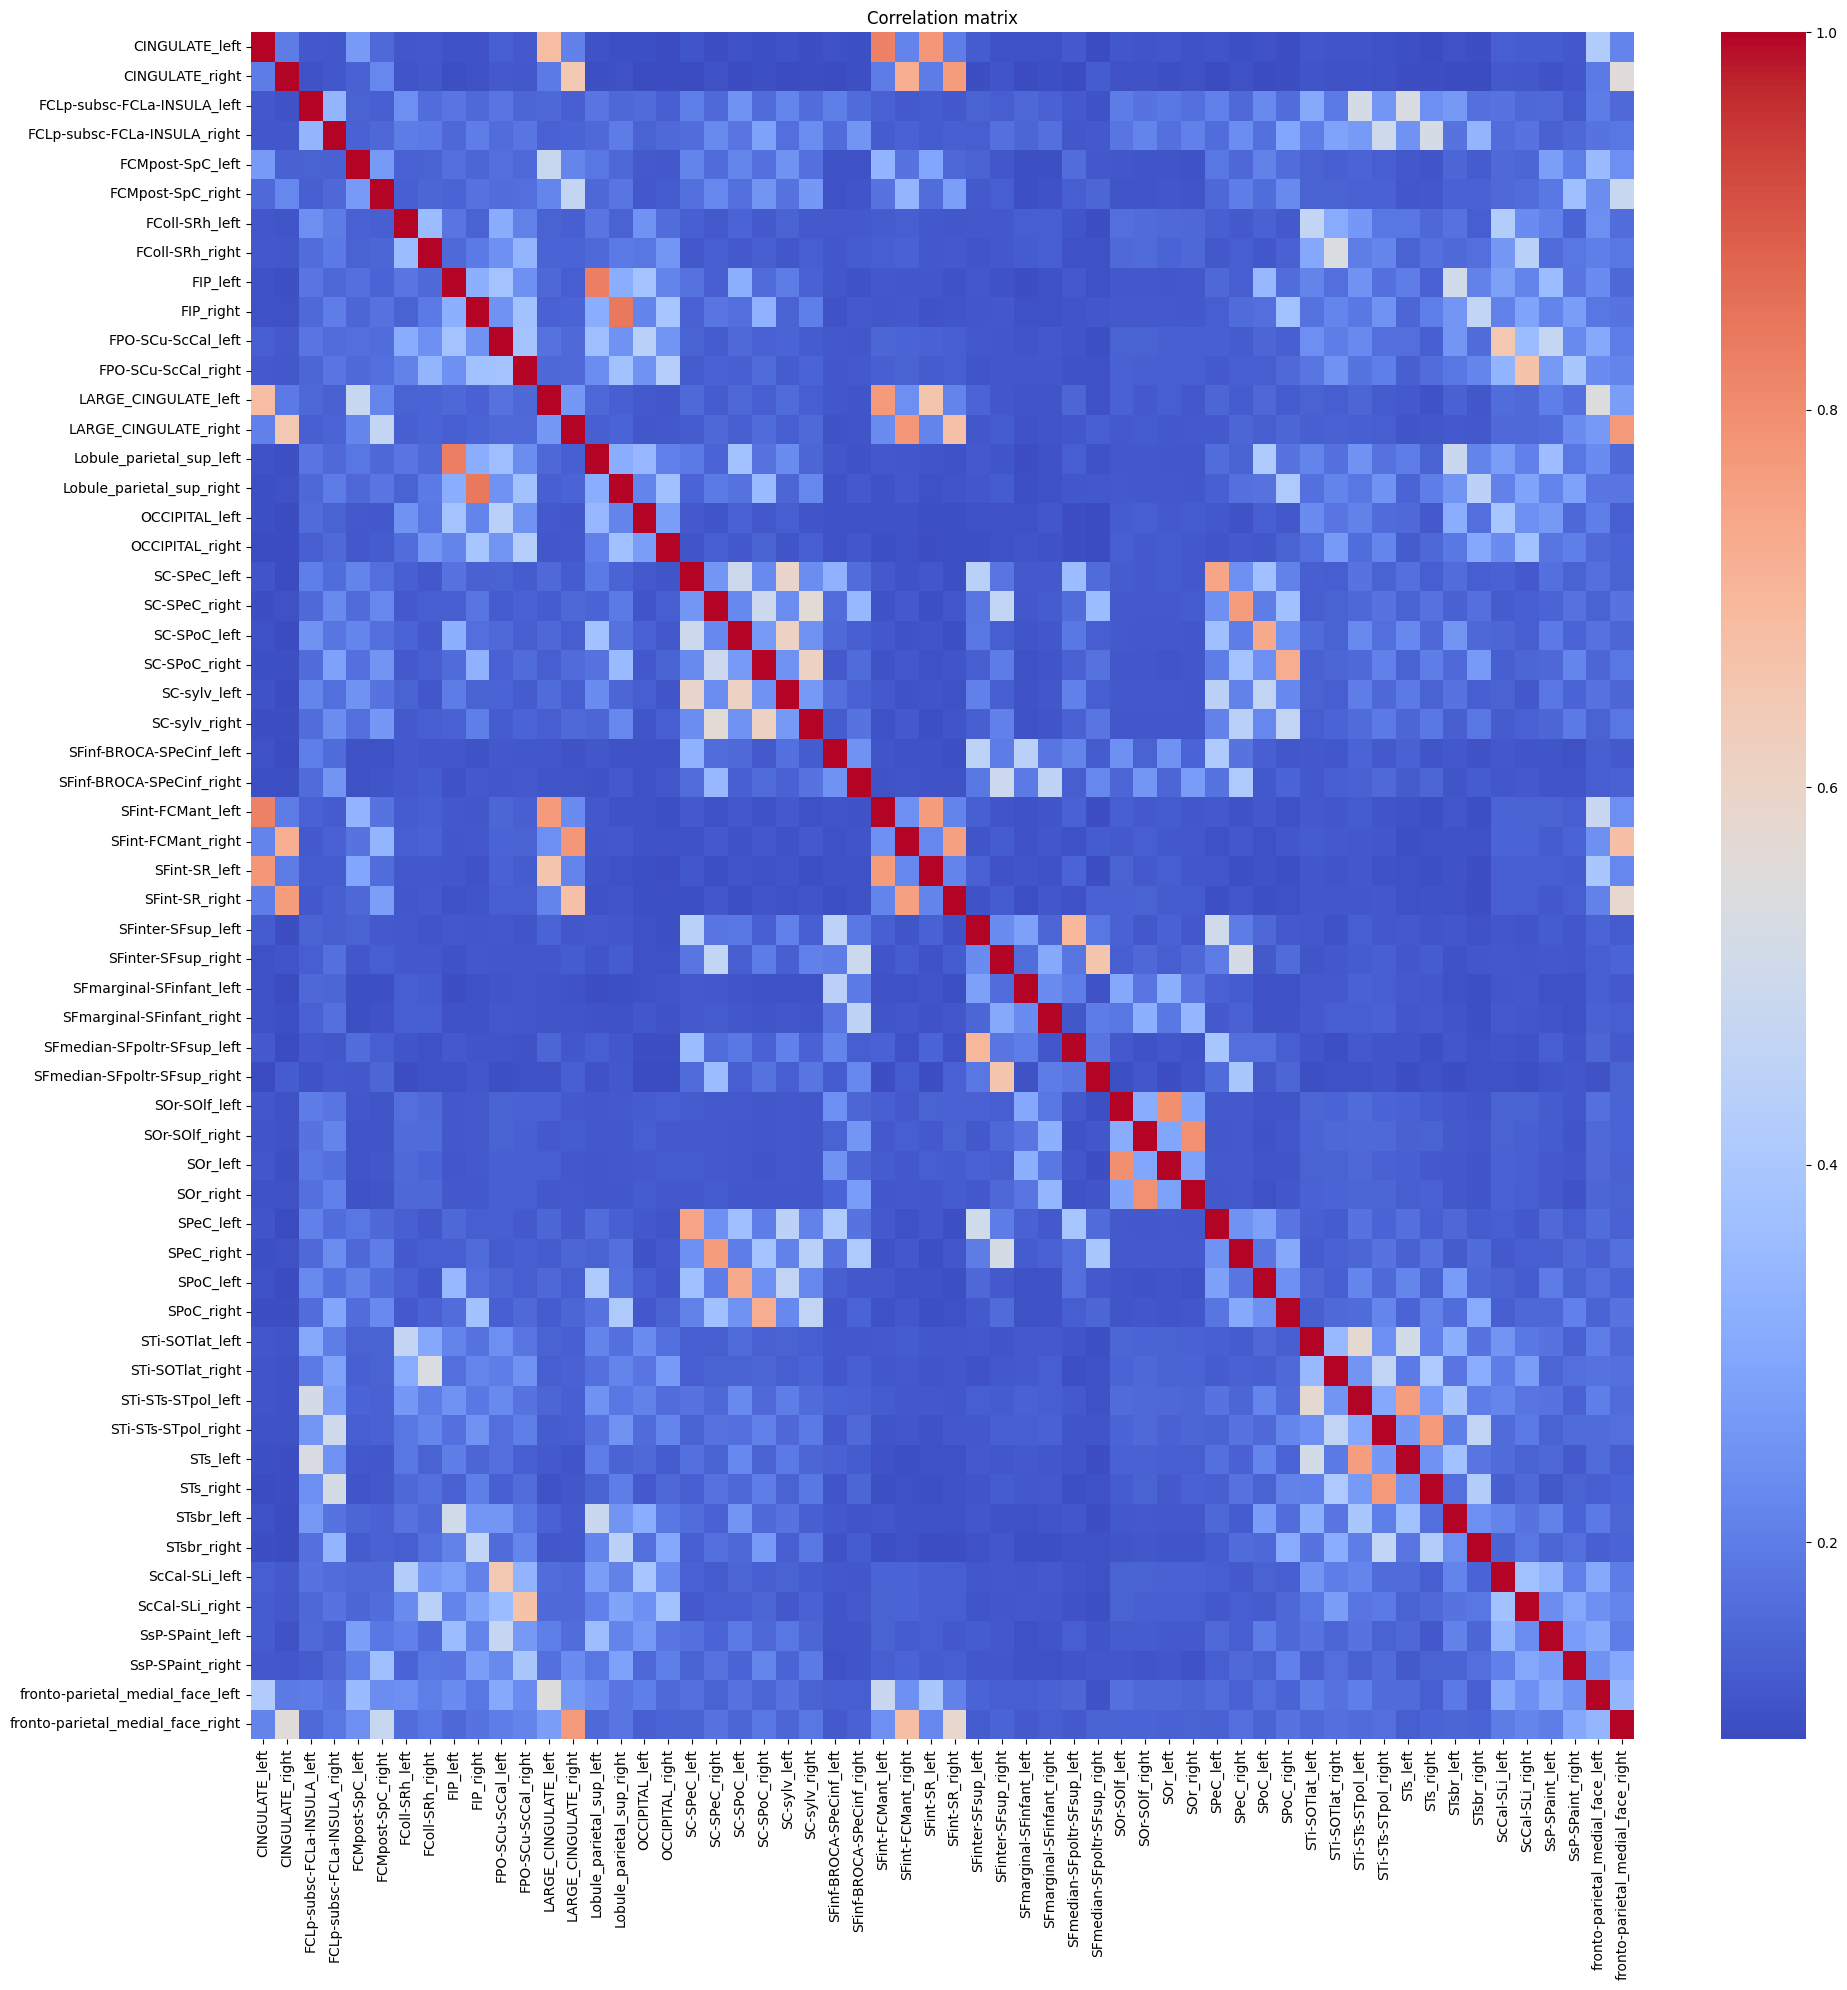

In [158]:
import seaborn as sns
# plot the correlation matrix with the regions names
plt.figure(figsize=(20, 20))
sns.heatmap(score_matrix, xticklabels=regions_treated, yticklabels=regions_treated, cmap='coolwarm', annot=False)
plt.title('Correlation matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

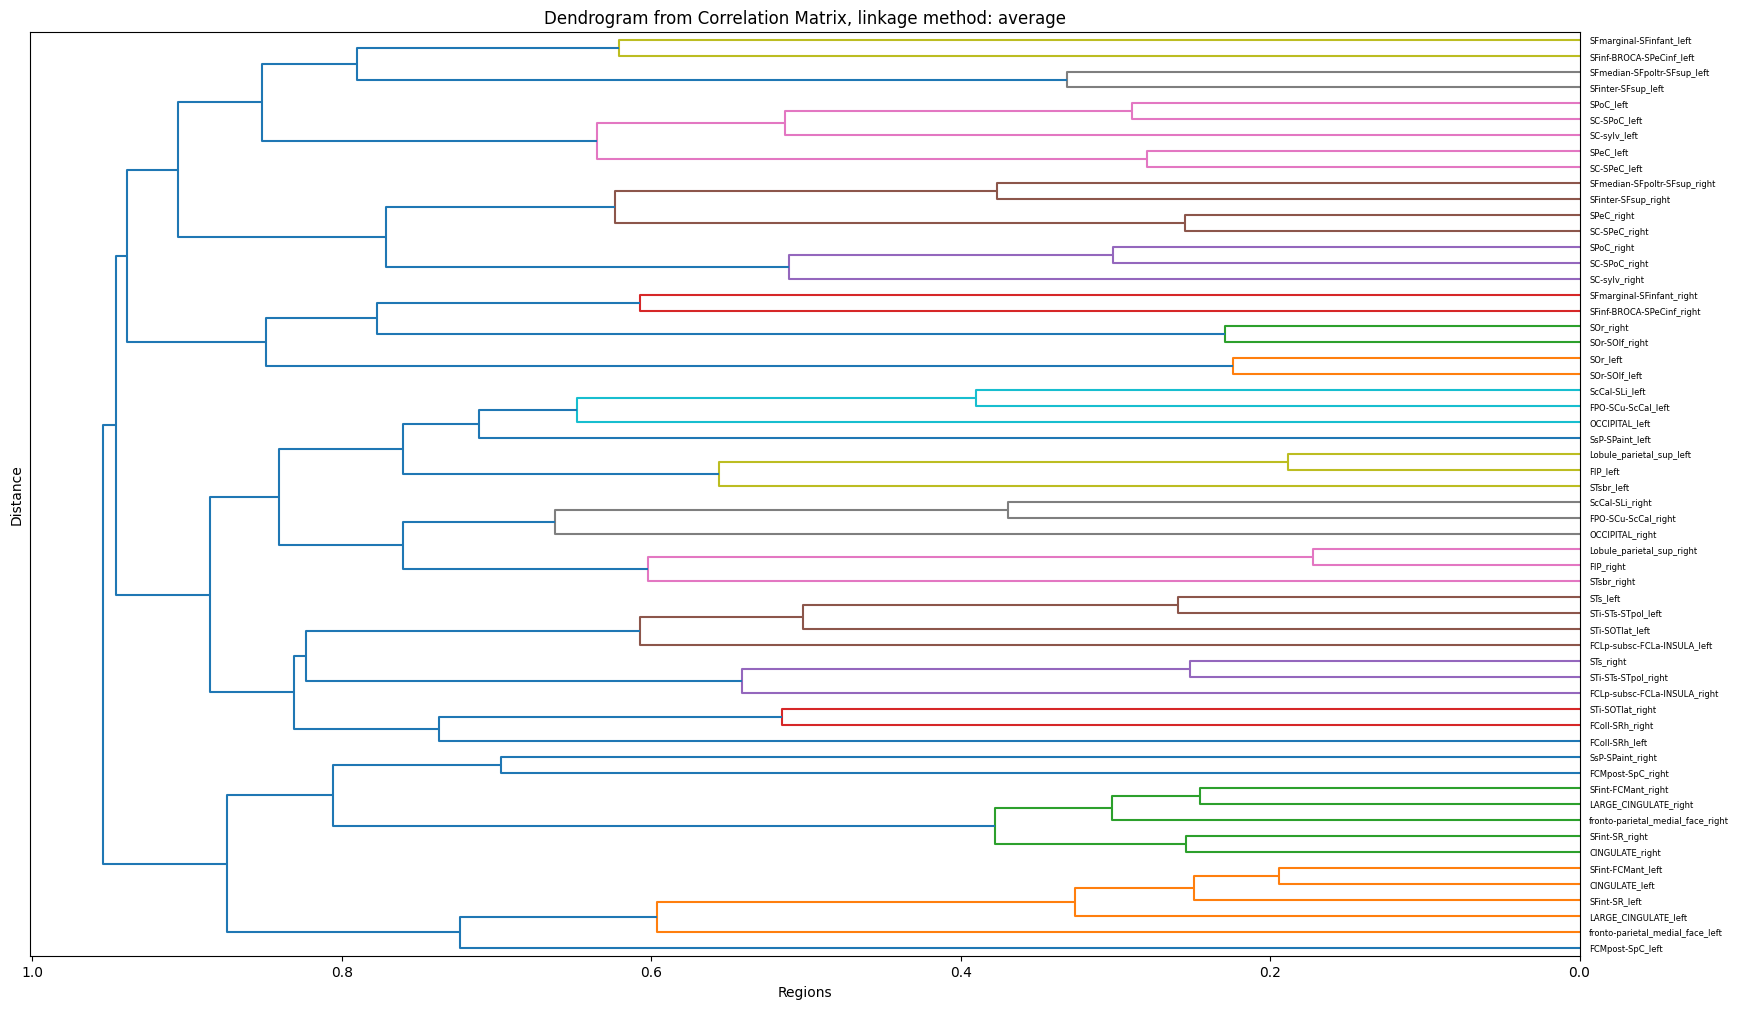

In [97]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

method = 'average'  # or 'ward', 'single', 'complete'

# 1. Example: your correlation matrix (symmetric with 1s on the diagonal)
# normalize the score_matrix
score_matrix = (score_matrix - score_matrix.min()) / (score_matrix.max() - score_matrix.min())

# 2. Convert correlation to distance (distance = 1 - correlation)
distance_matrix = 1 - score_matrix

# 3. Convert to condensed form (since linkage expects condensed matrix)
condensed_distance = squareform(distance_matrix)

# 4. Perform hierarchical clustering
linkage_matrix = sch.linkage(condensed_distance, method=method)  # or 'ward', 'single', 'complete'

# 5. Plot the dendrogram
plt.figure(figsize=(20, 12))
dendrogram = sch.dendrogram(linkage_matrix, labels=regions_treated, orientation='left')
plt.title("Dendrogram from Correlation Matrix, linkage method: " + method)
plt.xlabel("Regions")
plt.ylabel("Distance")
plt.show()

# eigenvectors

NB : how to interpret these directions ? How are they influenced by the values reported on the diagonal ? Here 0, but it should be max correlation.
Wouldn't it be better to apply a PCA on the concat space and try to retrieve from which regions come the obtained directions ? Some may come from a single regions, others from all regions (global variables) etc...

Even with this current approach, a direction should correspond to a covariance of multiple regions together, thus a direction of interest. But, not as intuitive as PCA, what exactly represent the eigenvectors in this case ? Do they really represent directions in a space of interest ?

The first eigenvector of a symmetric matrix is the vector that maximizes the variance of the data points after projection on the vector. But in this case, there is no data point anymore !!

What seems unclear is that directions of the latent space may be used multiple times to define global directions of interest ?

With the PCA approach (on concat space), need to apply standard scaler ? Yes probably
Try to find directions in the concat space, and assess from which combinations of regions they come ?

In [159]:
# compute the eigenvalues and eigenvectors of the correlation matrix
eigenvalues, eigenvectors = np.linalg.eig(score_matrix)
# sort the eigenvalues and eigenvectors
# the matrix is symmetric so all eigenvalues are positive
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

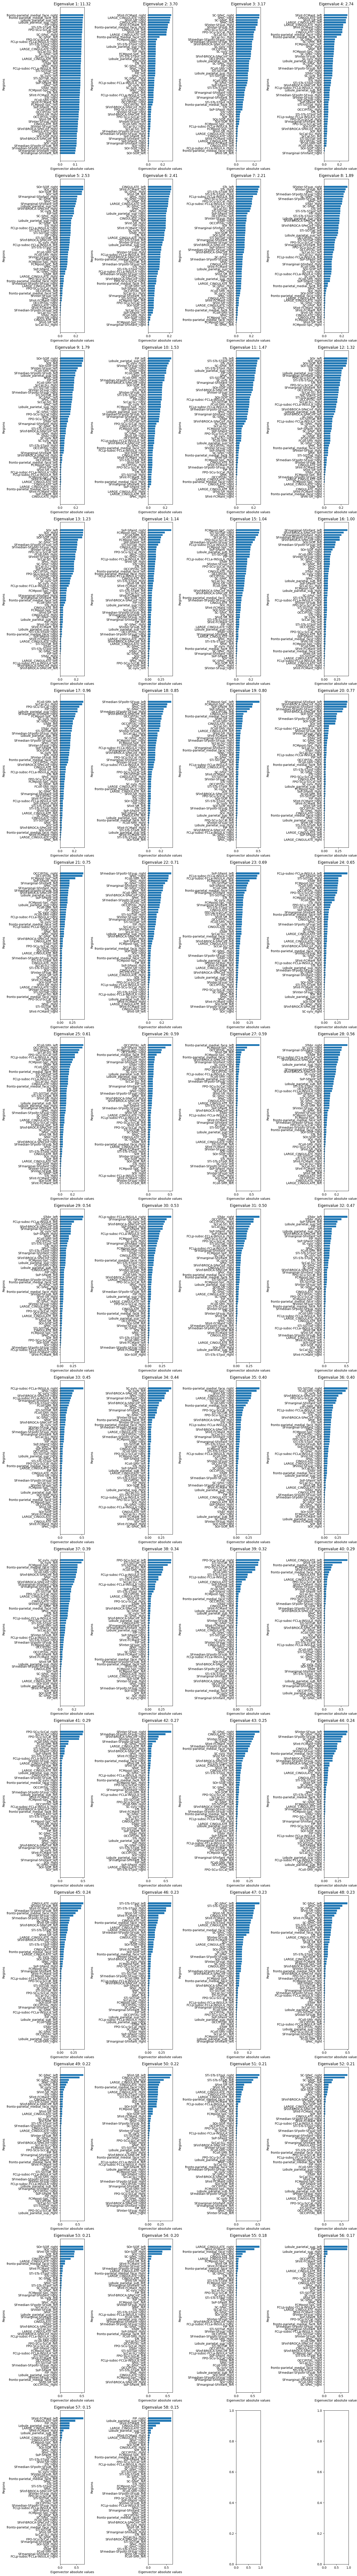

In [162]:
# for the largest N eigenvalues, find the dimensions contributing the most to the eigenvector
N = 58 # multiple of 4
fig, axs = plt.subplots(ncols=4, nrows=N//4 + 1, figsize=(16, N*2))
for i in range(N):
    ax = axs[i//4][i%4]
    # sort the eigenvector
    absolute_values = np.abs(eigenvectors[:, i])
    # get the indices of the sorted eigenvector (descending order)
    idx = np.argsort(absolute_values)
    # get the regions corresponding to the largest eigenvector values
    regions = [regions_treated[j] for j in idx]
    # plot the components
    ax.barh(np.arange(len(regions)), absolute_values[idx])
    ax.set_yticks(np.arange(len(regions)), regions)
    ax.set_title(f"Eigenvalue {i+1}: {eigenvalues[i]:.2f}")
    ax.set_xlabel("Eigenvector absolute values")
    ax.set_ylabel("Regions")
plt.tight_layout()
plt.show()